In [1]:
# =====================================================================
# Cellule 1 - Imports
# =====================================================================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cvxpy as cp
from sklearn.covariance import LedoitWolf
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
# %%
# =====================================================================
# Cellule 2 - Config (on garde le schéma start/end)
# =====================================================================

PRICES_FILE = "stocks_adj_close.txt"
META_FILE = "stocks_metadata.txt"

# tes dates "théoriques"
IN_SAMPLE_START = "2020-04-01"
IN_SAMPLE_END   = "2025-03-31"
OOS_START       = "2025-04-01"
OOS_END         = "2025-10-31"   # jusqu'au bout

# si ces dates ne marchent pas (pas de données), on fera un fallback auto

# param de sampling
N_ASSETS = 15

# ====== ⬇️ Toggle de l'estimateur de risque (EWMA ou GARCH) ======
USE_GARCH     = False     # True => GARCH(1,1) univarié + corr shrinkée ; False => EWMA (RiskMetrics)
EWMA_LAMBDA   = 0.94      # paramètre EWMA (RiskMetrics)
GARCH_DIST    = "t"       # "normal" ou "t" pour la loi des innovations (GARCH)
MIN_OBS_GARCH = 250       # nb minimal d'observations par actif pour estimer GARCH


In [3]:
# %%
# =====================================================================
# Cellule 3 - Charger et nettoyer les .txt
# =====================================================================
def load_dataset_from_txt(
    prices_path: str = PRICES_FILE,
    meta_path: str = META_FILE,
    markets_to_keep=("NYQ", "NMS"),
    min_valid_days=200,
):
    prices = pd.read_csv(prices_path, sep="\t", index_col=0, parse_dates=True)
    prices = prices.sort_index()
    meta = pd.read_csv(meta_path, sep="\t", encoding="utf-8")

    # clean tickers
    meta["Ticker"] = (
        meta["Ticker"]
        .astype(str)
        .str.strip()
        .str.lower()
        .str.replace("-", "", regex=False)
    )
    prices.columns = (
        prices.columns
        .str.strip()
        .str.lower()
        .str.replace("-", "", regex=False)
    )
    prices = prices.loc[:, ~prices.columns.duplicated()]  # colonnes uniques

    # filtrer metadata (au moins 2 champs renseignés)
    required = ["Ticker", "Company", "Market", "Sector", "MarketCap"]
    meta = meta[meta[required].notna().sum(axis=1) >= 2]

    # filtrer sur les marchés
    markets_upper = [m.upper() for m in markets_to_keep]
    meta["Market"] = meta["Market"].astype(str).str.strip().str.upper()
    meta = meta[meta["Market"].isin(markets_upper)]

    # nettoyer prix
    adj_close = prices.dropna(axis=1, how="all").replace(0, np.nan)
    adj_close = adj_close.loc[:, adj_close.notna().sum() > min_valid_days]
    # garder seulement les tickers retenus
    adj_close = adj_close.loc[:, adj_close.columns.isin(meta["Ticker"].unique())]

    # log-returns (base pour la timeline)
    log_returns = np.log(adj_close / adj_close.shift(1))
    log_returns = log_returns.replace([np.inf, -np.inf], np.nan)

    # garder les lignes avec assez de colonnes
    log_returns = log_returns.dropna(axis=0, thresh=int(max(1, log_returns.shape[1] * 0.5)))
    # garder les colonnes avec au moins 2 valeurs
    log_returns = log_returns.loc[:, log_returns.count() > 1]

    print(f"✅ log_returns: {log_returns.shape}")
    return adj_close, log_returns, meta

adj_close, log_returns, meta_df = load_dataset_from_txt()


✅ log_returns: (1254, 3354)


In [4]:
# %%
# =====================================================================
# Cellule 4 - Estimateurs (mu, cov) statiques
# =====================================================================

def _to_psd(cov: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    """Projette une matrice symétrique sur le cône PSD en relevant les VP négatives."""
    cov = 0.5 * (cov + cov.T)
    w, V = np.linalg.eigh(cov)
    w = np.clip(w, eps, None)
    cov_psd = V @ np.diag(w) @ V.T
    return 0.5 * (cov_psd + cov_psd.T)

def estimate_mean_cov(log_returns: pd.DataFrame, use_shrink: bool = True):
    """
    Reçoit des retours LOG; estime mu et cov sur retours ARITHMÉTIQUES (statique).
    - mu = moyenne arithmétique
    - cov = Ledoit–Wolf (par défaut) ou empirique, puis projection PSD
    """
    Rlog = log_returns.dropna(how="all").dropna(axis=1, thresh=2)
    if Rlog.shape[1] < 1:
        raise ValueError("Fenêtre trop vide pour l'estimation.")

    R = np.expm1(Rlog)              # retours arithmétiques
    mu = R.mean().values

    if use_shrink:
        try:
            lw = LedoitWolf().fit(R.values)
            cov = lw.covariance_
        except Exception:
            cov = R.cov().values
    else:
        cov = R.cov().values

    cov = np.nan_to_num(cov, nan=0.0)
    cov = _to_psd(cov)
    return mu, cov


In [5]:
# =====================================================================
# Cellule 5 - Solveurs Markowitz & robustes (avec fallback multi-solveurs)
# =====================================================================

# ---------- Helpers num ---------- #
def _nearest_psd(A: np.ndarray, eps: float = 1e-10) -> np.ndarray:
    A = np.array(A, dtype=float)
    A = 0.5 * (A + A.T)
    w, V = np.linalg.eigh(A)
    w = np.clip(w, eps, None)
    A_psd = (V * w) @ V.T
    return 0.5 * (A_psd + A_psd.T)

def _sqrt_psd(A: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    """Retourne B tel que B @ B.T ≈ A (racine PSD stable)."""
    A = _nearest_psd(A, eps=eps)
    w, V = np.linalg.eigh(A)
    w = np.clip(w, 0.0, None)
    B = (V * np.sqrt(w)) @ V.T
    return B

def _cap_constraint(n: int, cap):
    if cap is None:
        return []
    cap_eff = max(float(cap), 1.0 / n + 1e-6)
    return [w <= cap_eff]

# ---------- Fallback solveur (si disparu d'une autre cellule) ---------- #
if "_solve" not in globals():
    def _solve(prob: cp.Problem,
               preferred: tuple = ("ECOS", "OSQP", "SCS", "CLARABEL"),
               max_tries: int = 2,
               verbose: bool = False,
               **kwargs) -> str:
        installed = set(cp.installed_solvers())
        tried = []

        order = [s for s in preferred if s in installed]
        if "SCS" in installed and "SCS" not in order:
            order.append("SCS")
        if not order:
            order = [None]  # AUTO

        for s in order:
            for _ in range(max_tries):
                try:
                    if s is None:
                        prob.solve(verbose=verbose, **kwargs)
                    else:
                        prob.solve(solver=s, verbose=verbose, **kwargs)
                    if prob.status in ("optimal", "optimal_inaccurate"):
                        return prob.solver_stats.solver_name if prob.solver_stats else (s or "AUTO")
                except Exception as e:
                    tried.append((s or "AUTO", str(e)))
                    continue

        # tentative finale auto
        if None not in order:
            try:
                prob.solve(verbose=verbose, **kwargs)
                if prob.status in ("optimal", "optimal_inaccurate"):
                    return prob.solver_stats.solver_name if prob.solver_stats else "AUTO"
            except Exception as e:
                tried.append(("AUTO", str(e)))

        msg = "Tous les solveurs ont échoué. " + " | ".join(f"[{svr}] {err}" for svr, err in tried[-4:])
        raise RuntimeError(msg)

# ---------- Solveur Markowitz standard ---------- #
def solve_markowitz(mu: np.ndarray,
                    cov: np.ndarray,
                    lambda_risk: float = 1.0,
                    long_only: bool = True,
                    cap=None) -> np.ndarray:
    """
    max_w  mu^T w - lambda * w^T cov w
    s.c.   1^T w = 1, w >= 0 (si long_only), w <= cap (optionnel)
    """
    mu = np.asarray(mu).reshape(-1)
    cov = _nearest_psd(np.asarray(cov))
    n = len(mu)
    assert cov.shape == (n, n)

    global w  # pour _cap_constraint
    w = cp.Variable(n)
    cons = [cp.sum(w) == 1]
    if long_only:
        cons.append(w >= 0)
    cons += _cap_constraint(n, cap)

    obj = cp.Maximize(mu @ w - lambda_risk * cp.quad_form(w, cov))
    prob = cp.Problem(obj, cons)
    _solve(prob, verbose=False)
    if w.value is None:
        raise RuntimeError("Solveur Markowitz a échoué.")
    wv = np.maximum(w.value, 0.0)
    s = float(wv.sum())
    return (wv / s) if s > 1e-12 else np.ones(n) / n

# ---------- Solveur robuste : Box (L∞ sur μ) ---------- #
def solve_box_robust(mu: np.ndarray,
                     cov: np.ndarray,
                     delta_level: float,
                     lambda_risk: float = 1.0,
                     long_only: bool = True,
                     cap=None) -> np.ndarray:
    """
    max_w  mu^T w - delta * ||w||_1 - lambda * w^T cov w
    s.c.   1^T w = 1, w >= 0 (si long_only), w <= cap
    Interprétation : incertitude 'box' sur la moyenne → pénalité L1 sur w.
    """
    mu = np.asarray(mu).reshape(-1)
    cov = _nearest_psd(np.asarray(cov))
    n = len(mu)

    global w
    w = cp.Variable(n)
    cons = [cp.sum(w) == 1]
    if long_only:
        cons.append(w >= 0)
    cons += _cap_constraint(n, cap)
    scale = np.sqrt(np.clip(np.diag(cov), 1e-12, None))  # proxy d'incertitude par actif
    pen_box = float(delta_level) * cp.norm1(cp.multiply(scale, w))
    obj = cp.Maximize(mu @ w - pen_box - lambda_risk * cp.quad_form(w, cov))
    prob = cp.Problem(obj, cons)
    _solve(prob, verbose=False)
    if w.value is None:
        raise RuntimeError("Solveur Box-robust a échoué.")
    wv = np.maximum(w.value, 0.0)
    s = float(wv.sum())
    return (wv / s) if s > 1e-12 else np.ones(n) / n

# ---------- Solveur robuste : Ellipsoid (L2 pondérée par Σ sur μ) ---------- #
def solve_ellipsoid_robust(mu: np.ndarray,
                           cov: np.ndarray,
                           rho_level: float,
                           lambda_risk: float = 1.0,
                           long_only: bool = True,
                           cap=None) -> np.ndarray:
    """
    max_w  mu^T w - rho * || Σ^{1/2} w ||_2 - lambda * w^T Σ w
    s.c.   1^T w = 1, w >= 0 (si long_only), w <= cap
    Interprétation : incertitude ellipsoïdale sur μ avec forme ~Σ.
    """
    mu = np.asarray(mu).reshape(-1)
    cov = _nearest_psd(np.asarray(cov))
    n = len(mu)
    S12 = _sqrt_psd(cov)

    global w
    w = cp.Variable(n)
    cons = [cp.sum(w) == 1]
    if long_only:
        cons.append(w >= 0)
    cons += _cap_constraint(n, cap)

    obj = cp.Maximize(mu @ w - float(rho_level) * cp.norm2(S12 @ w) - lambda_risk * cp.quad_form(w, cov))
    prob = cp.Problem(obj, cons)
    _solve(prob, verbose=False)
    if w.value is None:
        raise RuntimeError("Solveur Ellipsoid-robust a échoué.")
    wv = np.maximum(w.value, 0.0)
    s = float(wv.sum())
    return (wv / s) if s > 1e-12 else np.ones(n) / n

# ---------- Solveur robuste : Budgeted (Bertsimas–Sim) ---------- #
def solve_budgeted_robust(mu: np.ndarray,
                          cov: np.ndarray,
                          delta: np.ndarray,
                          gamma: float,
                          lambda_risk: float = 1.0,
                          long_only: bool = True,
                          cap=None) -> np.ndarray:
    """
    max_w  mu^T w - gamma * || delta ∘ w ||_1 - lambda * w^T Σ w
    s.c.   1^T w = 1, w >= 0 (si long_only), w <= cap
    où (delta ∘ w)_i = delta_i * w_i  (norme L1 pondérée).
    """
    mu = np.asarray(mu).reshape(-1)
    cov = _nearest_psd(np.asarray(cov))
    delta = np.asarray(delta).reshape(-1)
    n = len(mu)
    assert delta.shape == (n,)

    global w
    w = cp.Variable(n)
    cons = [cp.sum(w) == 1]
    if long_only:
        cons.append(w >= 0)
    cons += _cap_constraint(n, cap)

    pen = float(gamma) * cp.norm1(cp.multiply(delta, w))
    obj = cp.Maximize(mu @ w - pen - lambda_risk * cp.quad_form(w, cov))
    prob = cp.Problem(obj, cons)
    _solve(prob, verbose=False)
    if w.value is None:
        raise RuntimeError("Solveur Budgeted-robust a échoué.")
    wv = np.maximum(w.value, 0.0)
    s = float(wv.sum())
    return (wv / s) if s > 1e-12 else np.ones(n) / n

# ---------- Solveur robuste : Wasserstein (L2 sur w) ---------- #
def solve_wasserstein_robust(mu: np.ndarray,
                             cov: np.ndarray,
                             eps_level: float,
                             lambda_risk: float = 1.0,
                             long_only: bool = True,
                             cap=None) -> np.ndarray:
    """
    max_w  mu^T w - eps * ||w||_2 - lambda * w^T Σ w
    s.c.   1^T w = 1, w >= 0 (si long_only), w <= cap
    Interprétation : DRO Wasserstein (incertitude sur μ) → pénalité L2 sur w.
    """
    mu = np.asarray(mu).reshape(-1)
    cov = _nearest_psd(np.asarray(cov))
    n = len(mu)

    global w
    w = cp.Variable(n)
    cons = [cp.sum(w) == 1]
    if long_only:
        cons.append(w >= 0)
    cons += _cap_constraint(n, cap)

    obj = cp.Maximize(mu @ w - float(eps_level) * cp.norm2(w) - lambda_risk * cp.quad_form(w, cov))
    prob = cp.Problem(obj, cons)
    _solve(prob, verbose=False)
    if w.value is None:
        raise RuntimeError("Solveur Wasserstein-robust a échoué.")
    wv = np.maximum(w.value, 0.0)
    s = float(wv.sum())
    return (wv / s) if s > 1e-12 else np.ones(n) / n



In [6]:
# %%
# =====================================================================
# Cellule 6 - Metrics (patch NaN-safe + compat pandas>=2)
# =====================================================================
def portfolio_gross_from_log_returns(log_ret_df: pd.DataFrame, w: np.ndarray) -> pd.Series:
    """
    Gross daily returns du portefeuille, avec renormalisation des poids
    les jours où certains actifs sont manquants. NaN-safe.
    """
    G = np.exp(log_ret_df)                              # T x N (gross individuels)
    W = np.asarray(w, dtype=float).reshape(1, -1)       # 1 x N

    # masque de présence (1 si dispo, 0 sinon)
    M = (~G.isna()).astype(float).values                # T x N

    # numérateur : somme pondérée en ignorant les NaN
    num = np.nansum(G.values * W, axis=1)               # T

    # dénominateur : somme des poids présents ce jour-là
    den = (M @ W.T).ravel()                             # T
    den = np.where(den <= 1e-12, 1.0, den)              # évite division par zéro

    Gp = num / den                                      # gross return du portefeuille
    return pd.Series(Gp, index=log_ret_df.index)

def portfolio_path_from_log_returns(log_ret_df: pd.DataFrame, w: np.ndarray, start_nav: float = 1.0) -> pd.Series:
    """
    Série NAV à partir du premier jour de log_ret_df (compat pandas>=2 : pas de .append).
    """
    Gp = portfolio_gross_from_log_returns(log_ret_df, w)
    nav = start_nav * Gp.cumprod()
    return nav


In [7]:
# =====================================================================
# Cellule 7 - IS/OOS
# =====================================================================
lr = log_returns.sort_index()

def make_is_oos_from_config(lr, is_start, is_end, oos_start, oos_end):
    try:
        is_part = lr.loc[is_start:is_end].dropna(axis=1, how="all")
        if oos_start is None:
            oos_part = lr.loc[is_end:].dropna(axis=1, how="all")
        else:
            oos_part = lr.loc[oos_start:oos_end].dropna(axis=1, how="all")
    except Exception:
        return None, None
    common = is_part.columns.intersection(oos_part.columns)
    is_part = is_part[common]
    oos_part = oos_part[common]
    if is_part.shape[0] == 0 or is_part.shape[1] == 0 or oos_part.shape[1] == 0:
        return None, None
    return is_part, oos_part

is_slice_cfg, oos_slice_cfg = make_is_oos_from_config(
    lr, IN_SAMPLE_START, IN_SAMPLE_END, OOS_START, OOS_END
)

if is_slice_cfg is None:
    print("⚠️ Période config vide → fallback auto (252 IS / 42 OOS)")
    IS_DAYS = 1119
    OOS_DAYS = 135
    oos_slice = lr.iloc[-OOS_DAYS:].dropna(axis=1, how="all")
    is_slice = lr.iloc[-(OOS_DAYS + IS_DAYS):-OOS_DAYS].dropna(axis=1, how="all")
else:
    is_slice = is_slice_cfg
    oos_slice = oos_slice_cfg

common_tickers = is_slice.columns.intersection(oos_slice.columns)
is_slice = is_slice[common_tickers]
oos_slice = oos_slice[common_tickers]

print("IS:", is_slice.shape, "OOS:", oos_slice.shape)


IS: (1119, 3353) OOS: (135, 3353)


In [8]:
# %%
# =====================================================================
# Cellule 8 - Expérience multi-modèles (timeline) - univers fixe (sans GARCH)
# =====================================================================

np.random.seed(42)

def _cap_feasible(n, cap):
    """Retourne un cap faisable pour ∑w=1, w>=0 : cap_eff >= 1/n."""
    if cap is None:
        return None
    min_cap = 1.0 / n + 1e-6
    return cap if cap >= min_cap else min_cap

# Grilles de paramètres (adimensionnées pour box/ellipsoid/wasserstein)
ROBUST_EXPERIMENT = {
    "markowitz":  {"params": [None]},
    "box":        {"params": [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0, 2.0]},
    "ellipsoid":  {"params": [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0, 2.0]},
    "budgeted":   {"params": [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0, 2.0]},
    "wasserstein":{"params": [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0, 2.0]},
}

# Structures de résultats
results_nav_models = {
    model: {p: [] for p in cfg["params"]}
    for model, cfg in ROBUST_EXPERIMENT.items()
}
results_weights_models = {
    model: {p: [] for p in cfg["params"]}
    for model, cfg in ROBUST_EXPERIMENT.items()
}

# Dates de rebalancement
rebal_dates = oos_slice.index.unique().sort_values()

# Hyperparamètres
IS_MIN_ROWS = 30                 # lignes mini en IS
IS_MIN_POINTS_PER_ASSET = 2      # points mini par actif en IS
OOS_MIN_POINTS_PER_ASSET = 1     # points mini par actif en OOS
MIN_ASSETS_AT_REBAL = 1          # autoriser 1 actif si nécessaire
LAMBDA_RISK = 1.0                # <-- même aversion au risque pour TOUS les modèles
ROBUST_CAP = 0.2                 # cap cible (relevé si nécessaire)

# Adaptation automatique des niveaux pour s'écarter de Markowitz
ADAPT_LEVEL_BOOSTS = [1.0, 3.0, 9.0, 27.0]
DIFF_TOL_L1 = 1e-3

# ===== Univers d'actifs fixé une fois =====
if len(common_tickers) < N_ASSETS:
    raise ValueError("Pas assez d'actifs dans common_tickers pour en sélectionner N_ASSETS.")
sel = np.random.choice(common_tickers, size=N_ASSETS, replace=False)
print(f"✅ Univers fixe sélectionné ({len(sel)} actifs)")

skip_stats = {"IS_rows":0, "OOS_rows":0, "cols_filter":0, "solve":0}
total_runs_before = sum(len(vv) for mm in results_nav_models.values() for vv in mm.values())

for i, rebalance_date in enumerate(rebal_dates):

    # IS et OOS (log-returns)
    is_trial = is_slice[sel].loc[:rebalance_date].copy()
    oos_trial = oos_slice[sel].loc[rebalance_date:].copy()

    # Garde-fous sur lignes
    if is_trial.dropna(how="all").shape[0] < IS_MIN_ROWS:
        skip_stats["IS_rows"] += 1
        continue
    if oos_trial.dropna(how="all").shape[0] < 1:
        skip_stats["OOS_rows"] += 1
        continue

    # Filtrage des colonnes (détendu)
    is_counts = is_trial.count(axis=0)
    oos_counts = oos_trial.count(axis=0)
    good_is_cols = is_counts[is_counts >= IS_MIN_POINTS_PER_ASSET].index
    good_oos_cols = oos_counts[oos_counts >= OOS_MIN_POINTS_PER_ASSET].index
    good_cols = [c for c in is_trial.columns if (c in good_is_cols and c in good_oos_cols)]
    is_trial = is_trial[good_cols]
    oos_trial = oos_trial[good_cols]

    if is_trial.shape[1] < MIN_ASSETS_AT_REBAL:
        skip_stats["cols_filter"] += 1
        continue

    # ===== Estimation mu, cov (STATIQUE) =====
    try:
        mu, cov = estimate_mean_cov(is_trial, use_shrink=True)
    except Exception:
        skip_stats["solve"] += 1
        continue

    n_assets_curr = len(mu)
    cap_eff = _cap_feasible(n_assets_curr, ROBUST_CAP)

    # ================= MARKOWITZ (retries & fallbacks) =================
    w_mk = None
    try:
        w_mk = solve_markowitz(
            mu, cov,
            lambda_risk=LAMBDA_RISK,   # uniforme
            long_only=True,
            cap=cap_eff
        )
    except Exception as e1:
        # Retry sans cap
        try:
            w_mk = solve_markowitz(
                mu, cov,
                lambda_risk=LAMBDA_RISK,
                long_only=True,
                cap=None
            )
            print(f"⚠️ {rebalance_date.date()}: Markowitz OK après retrait du cap (init: {e1})")
        except Exception as e2:
            # Fallback min-variance long-only
            try:
                w_var = cp.Variable(n_assets_curr, nonneg=True)
                prob = cp.Problem(cp.Minimize(cp.quad_form(w_var, cov)), [cp.sum(w_var) == 1])
                try:
                    _solve(prob, verbose=False)
                except Exception:
                    prob.solve(solver="SCS", verbose=False)
                if w_var.value is not None:
                    wv = np.maximum(w_var.value, 0)
                    s = float(wv.sum())
                    w_mk = (wv / s) if s > 1e-12 else np.ones(n_assets_curr)/n_assets_curr
                    print(f"⚠️ {rebalance_date.date()}: fallback min-variance (Markowitz KO: {e2})")
            except Exception:
                pass

    if w_mk is None:
        # Fallback équipondéré
        w_mk = np.ones(n_assets_curr) / n_assets_curr
        print(f"⚠️ {rebalance_date.date()}: fallback équipondéré (Markowitz et min-variance KO)")

    # NAV Markowitz (ou fallback) et stockage
    nav_mk = portfolio_path_from_log_returns(oos_trial, w_mk)
    results_nav_models["markowitz"][None].append(nav_mk)
    w_series_mk = pd.Series(w_mk, index=oos_trial.columns, name=rebalance_date)
    results_weights_models["markowitz"][None].append(w_series_mk)
    # ===================================================================

    # Base pour 'budgeted'
    base_delta_vec = 1.0 / np.maximum(np.sqrt(np.maximum(np.diag(cov), 0.0)), 1e-8)
    base_delta_vec = base_delta_vec / np.median(base_delta_vec)  # <-- normalisation



    # ================ AUTRES MODÈLES (adaptation auto du niveau) =================
    for model, cfg in ROBUST_EXPERIMENT.items():
        if model == "markowitz":
            continue
        for p in cfg["params"]:
            solved = False
            last_err = None

            # Pour "budgeted", on ne booste pas gamma
            boosts = ADAPT_LEVEL_BOOSTS if model in {"box","ellipsoid","wasserstein"} else [1.0]

            for boost in boosts:
                try:
                    level_eff = (0.0 if p is None else float(p) * boost)

                    if model == "box":
                        w = solve_box_robust(
                            mu, cov,
                            delta_level=level_eff,
                            lambda_risk=LAMBDA_RISK,
                            long_only=True,
                            cap=cap_eff,
                        )

                    elif model == "ellipsoid":
                        w = solve_ellipsoid_robust(
                            mu, cov,
                            rho_level=level_eff,
                            lambda_risk=LAMBDA_RISK,
                            long_only=True,
                            cap=cap_eff,
                        )

                    elif model == "budgeted":
                        delta_vec = base_delta_vec if base_delta_vec.size else np.array([0.01])
                        w = solve_budgeted_robust(
                            mu, cov,
                            delta=delta_vec,
                            gamma=float(p),
                            lambda_risk=LAMBDA_RISK,
                            long_only=True,
                            cap=cap_eff,
                        )

                    elif model == "wasserstein":
                        w = solve_wasserstein_robust(
                            mu, cov,
                            eps_level=level_eff,
                            lambda_risk=LAMBDA_RISK,
                            long_only=True,
                            cap=cap_eff,
                        )
                    else:
                        break  # modèle inconnu

                    # Si (quasi) identique à Markowitz, tenter un boost (sauf budgeted)
                    if model != "budgeted":
                        l1_dist = float(np.sum(np.abs(w - w_mk)))
                        if l1_dist < DIFF_TOL_L1 and boost != boosts[-1]:
                            continue  # retenter avec un level plus élevé
                        elif l1_dist < DIFF_TOL_L1:
                            print(f"ℹ️ {rebalance_date.date()}: {model} (param={p}) ~ Markowitz (|Δw|₁={l1_dist:.2e}) malgré boosts")
                        else:
                            if boost > 1.0:
                                print(f"✅ {rebalance_date.date()}: {model} (param={p} → {level_eff}) s'écarte de Markowitz (|Δw|₁={l1_dist:.3f})")

                    nav = portfolio_path_from_log_returns(oos_trial, w)
                    results_nav_models[model][p].append(nav)

                    w_series = pd.Series(w, index=oos_trial.columns, name=rebalance_date)
                    results_weights_models[model][p].append(w_series)

                    solved = True
                    break  # param suivant

                except Exception as e:
                    last_err = e
                    continue

            if not solved:
                print(f"⚠️ {rebalance_date.date()}: {model} (param={p}) a échoué ({last_err})")
                continue
    # ============================================================================

total_runs_after = sum(len(vv) for mm in results_nav_models.values() for vv in mm.values())
print(f"✅ Expérience terminée. Runs ajoutés: {total_runs_after - total_runs_before}")

# === Baseline de secours si zéro run (évite le 'aucun run trouvé' en Cellule 9) ===
if total_runs_after - total_runs_before == 0:
    print("⚠️ Aucun run généré ; création d'un baseline de secours égal-pondéré.")
    oos_pool = oos_slice[sel].copy()
    counts = oos_pool.count().sort_values(ascending=False)
    top_cols = counts.index.tolist()
    if len(top_cols) == 0:
        print("❌ OOS totalement vide : même le baseline de secours est impossible.")
    else:
        top_cols = top_cols[:min(10, len(top_cols))]
        oos_alt = oos_pool[top_cols]
        w_eq = np.ones(len(top_cols)) / len(top_cols)
        nav_eq = portfolio_path_from_log_returns(oos_alt, w_eq)
        results_nav_models["markowitz"][None].append(nav_eq)
        w_series_eq = pd.Series(w_eq, index=oos_alt.columns, name=oos_alt.index[0] if len(oos_alt.index) else None)
        results_weights_models["markowitz"][None].append(w_series_eq)
        print(f"✅ Baseline de secours ajouté ({len(top_cols)} actifs)")

print("Résumé des skips:", skip_stats)


✅ Univers fixe sélectionné (15 actifs)
✅ Expérience terminée. Runs ajoutés: 10935
Résumé des skips: {'IS_rows': 0, 'OOS_rows': 0, 'cols_filter': 0, 'solve': 0}


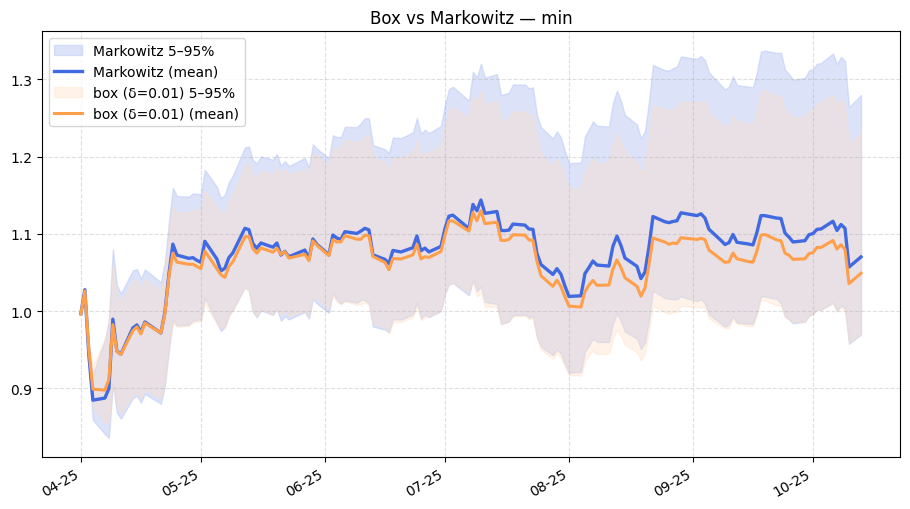

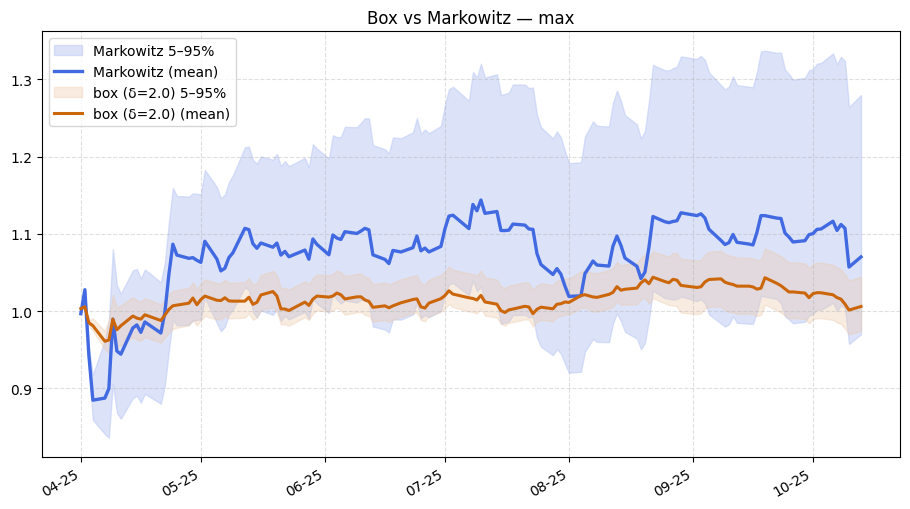

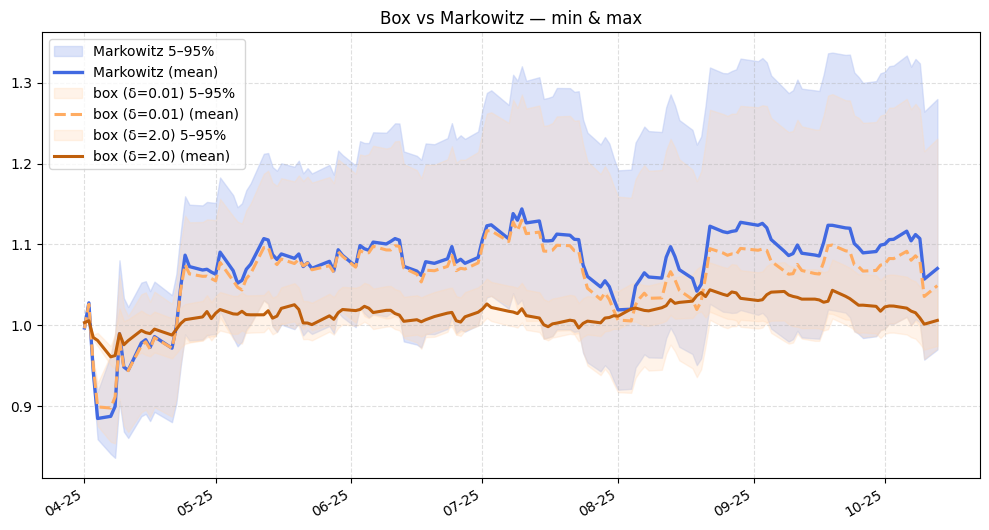

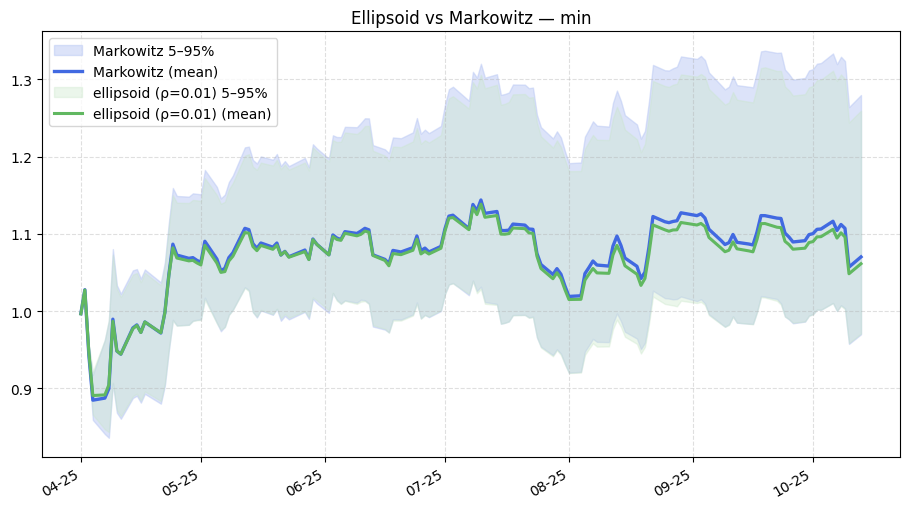

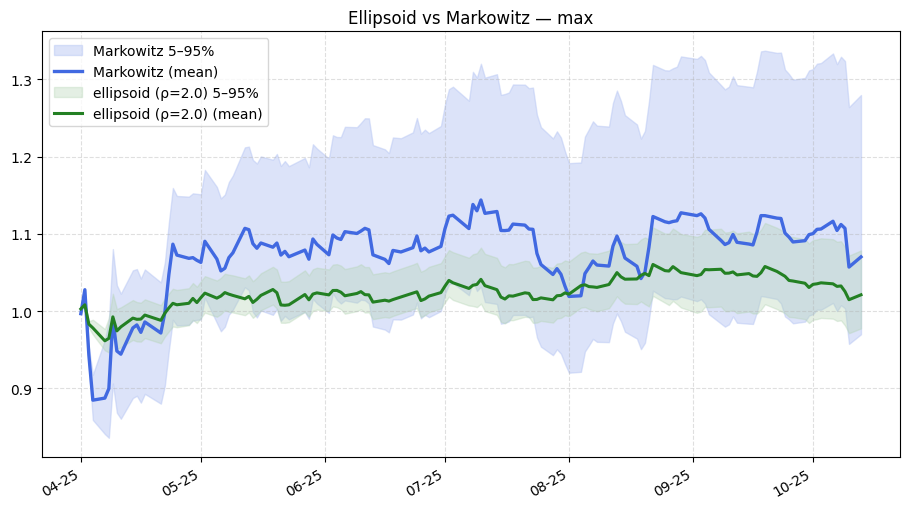

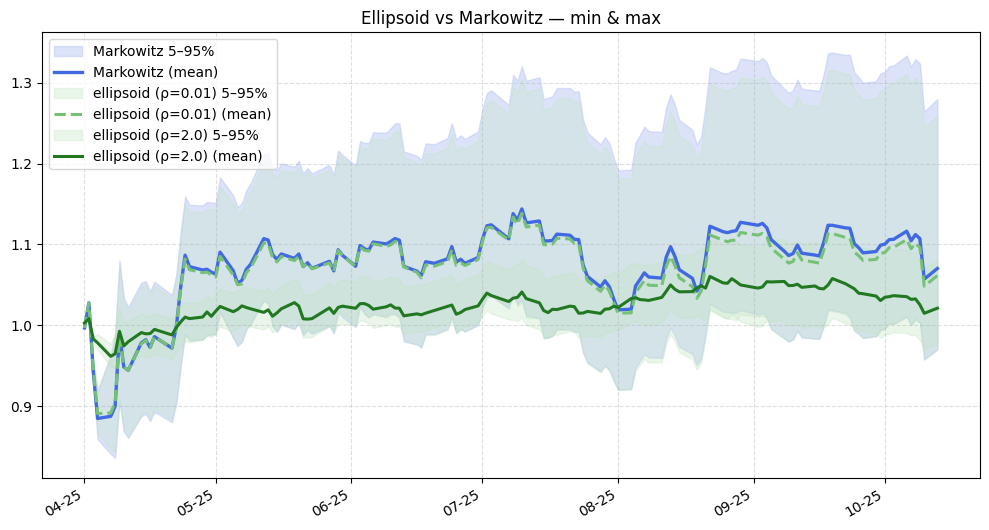

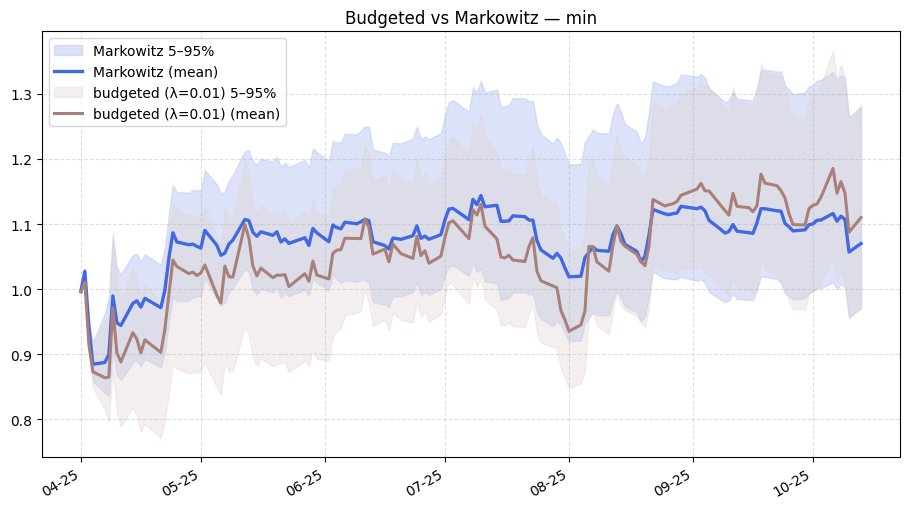

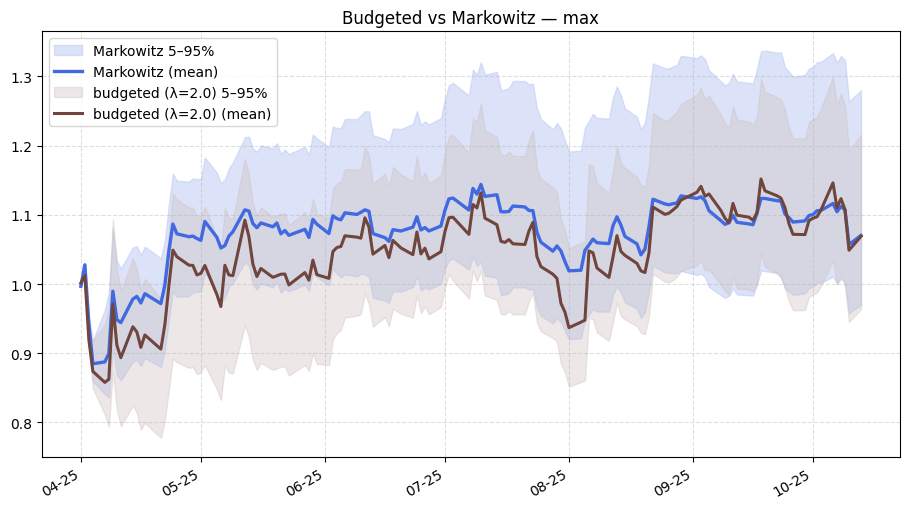

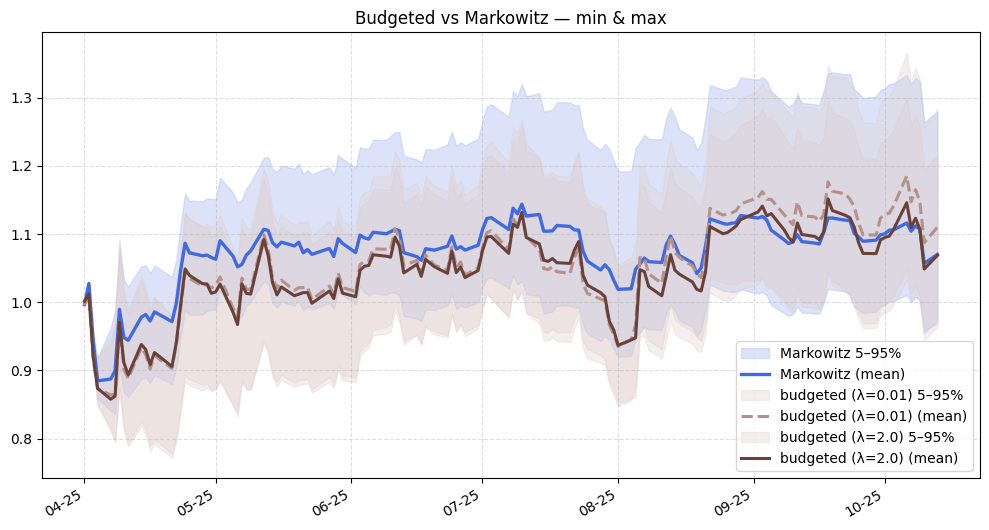

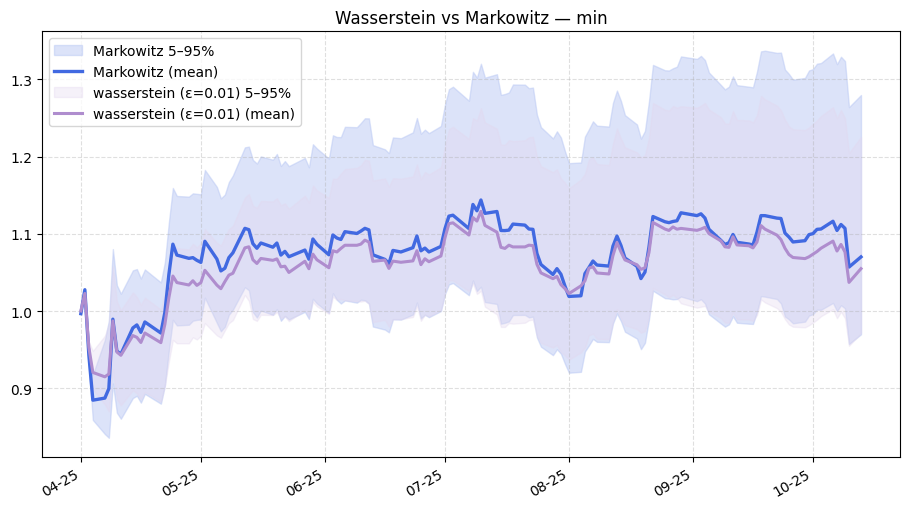

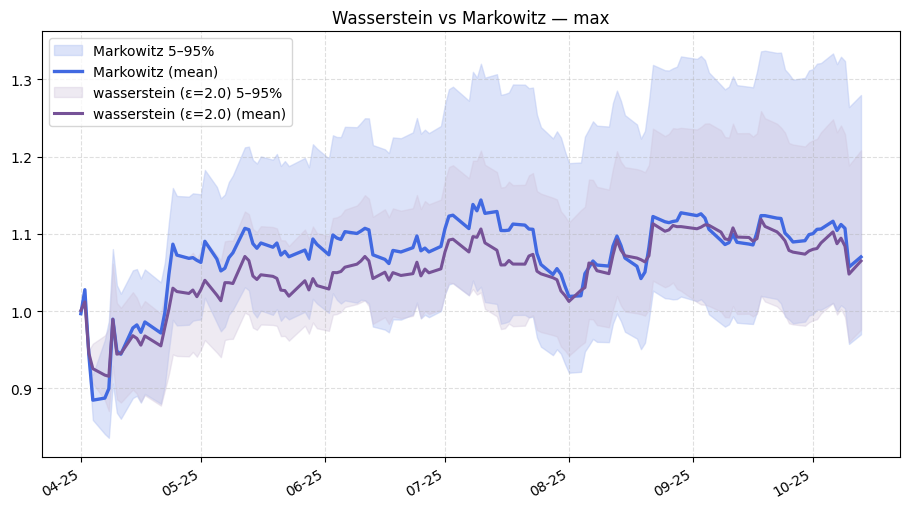

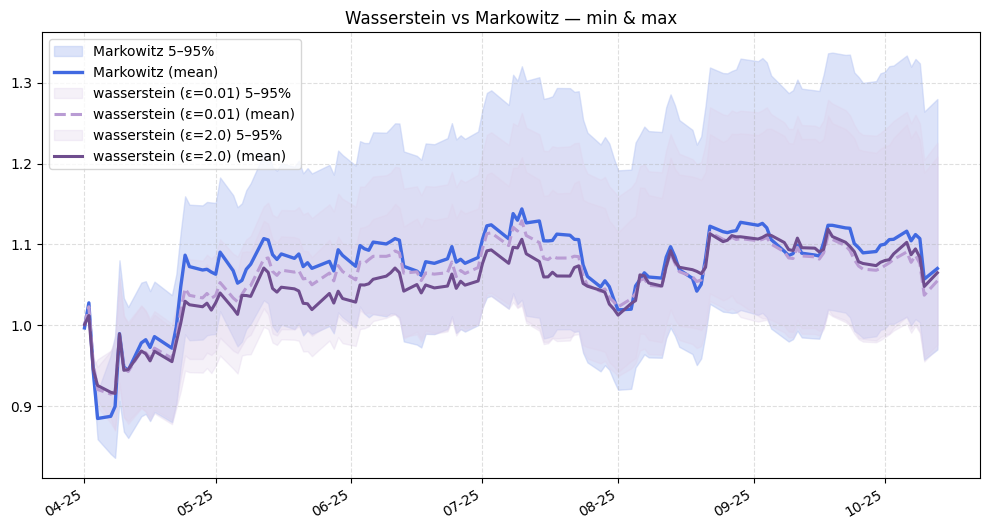

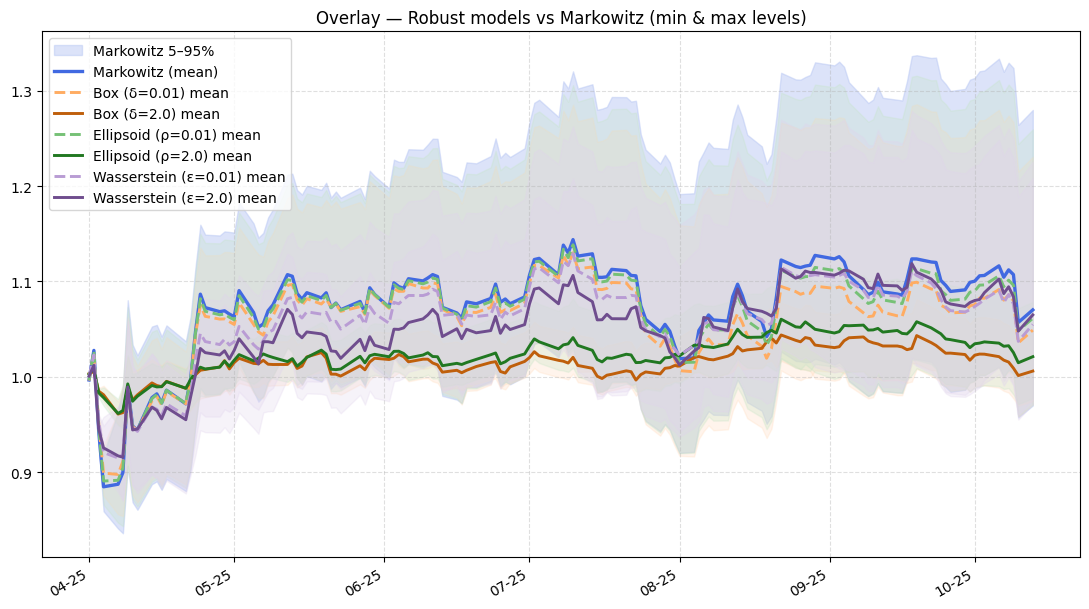

In [9]:
# =====================================================================
# Cell 9 — Compare each model to Markowitz (PDF-style)
#          + Overlay figure (all models together, means & 5–95% bands)
# =====================================================================

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# --- fixed palette for the presentation ---
COLOR_MAP = {
    "markowitz":  "#4169e1",  # Royal Blue
    "box":        "#ff7f0e",  # Orange
    "ellipsoid":  "#2ca02c",  # Green
    "budgeted":   "#8c564b",  # Brown
    "wasserstein":"#9467bd",  # Purple
}

# light/dark variations (for min/max)
def _lighten(color, amount=0.5):
    c = np.array(plt.matplotlib.colors.to_rgb(color))
    return tuple(c + (1 - c) * np.clip(amount, 0, 1))

def _darken(color, amount=0.2):
    c = np.array(plt.matplotlib.colors.to_rgb(color))
    return tuple(np.clip(c * (1 - np.clip(amount, 0, 1)), 0, 1))

def _get_markowitz_runs(results_nav_models: dict):
    mk_runs = results_nav_models.get("markowitz", {}).get(None, [])
    if not mk_runs:
        print("⚠️ No Markowitz runs, cannot compare.")
        return None
    df_mk = pd.concat(mk_runs, axis=1)
    return {
        "df":   df_mk,
        "mean": df_mk.mean(axis=1),
        "p5":   df_mk.quantile(0.05, axis=1),
        "p95":  df_mk.quantile(0.95, axis=1),
    }

def _param_items_with_runs(model_dict: dict):
    items = []
    for p, runs in (model_dict or {}).items():
        if runs:
            try: pf = float(p)
            except Exception: pf = None
            items.append((p, runs, pf))
    return items

def _pick_min_max_params(model_name: str, results_nav_models: dict):
    """
    Pick 'min' ≈ 0.01 and 'max' ≈ 2.0 among available params (preferring >0).
    If ties: for min prefer smaller value; for max prefer larger value.
    """
    TARGET_MIN, TARGET_MAX = 0.01, 2.0
    model_dict = results_nav_models.get(model_name, {})
    items = _param_items_with_runs(model_dict)
    if not items:
        return []

    # prefer strictly positive params if any; otherwise all numeric
    pos = [it for it in items if it[2] is not None and it[2] > 0.0]
    pool = pos or [it for it in items if it[2] is not None]

    if pool:
        def _pick_closest(pool, target, prefer="lower"):
            best = None; best_key = None
            for it in pool:
                val = it[2]
                dist = abs(val - target)
                tie_break = val if prefer == "lower" else -val
                key = (dist, tie_break)
                if best is None or key < best_key:
                    best, best_key = it, key
            return best

        lo_it = _pick_closest(pool, TARGET_MIN, prefer="lower")
        hi_it = _pick_closest(pool, TARGET_MAX, prefer="higher")
        pairs = []
        if lo_it: pairs.append((lo_it[0], lo_it[1]))
        if hi_it and (not lo_it or hi_it[0] != lo_it[0]):
            pairs.append((hi_it[0], hi_it[1]))
        return pairs

    # fallback: no numeric params → lexicographic
    items = sorted(items, key=lambda it: str(it[0]))
    return [(items[0][0], items[0][1])] if len(items) == 1 else [(items[0][0], items[0][1]), (items[-1][0], items[-1][1])]

def _mean_band(df: pd.DataFrame):
    mean = df.mean(axis=1)
    p5   = df.quantile(0.05, axis=1)
    p95  = df.quantile(0.95, axis=1)
    return mean, p5, p95

def _format_axes(ax, title):
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%y"))
    for lab in ax.get_xticklabels():
        lab.set_rotation(30); lab.set_ha("right")

def _sym(model_name: str) -> str:
    return {"box": "δ", "ellipsoid": "ρ", "wasserstein": "ε"}.get(model_name, "λ")

def _plot_baseline(ax, mk_stats):
    c = COLOR_MAP["markowitz"]
    ax.fill_between(mk_stats["df"].index, mk_stats["p5"], mk_stats["p95"],
                    color=_lighten(c, 0.60), alpha=0.45, label="Markowitz 5–95%")
    ax.plot(mk_stats["df"].index, mk_stats["mean"], color=c, linewidth=2.4,
            label="Markowitz (mean)")

def _plot_one_param_vs_mk(model_name: str, param, runs, mk_stats, color, title_suffix=""):
    df_mod = pd.concat(runs, axis=1)
    mod_mean, mod_p5, mod_p95 = _mean_band(df_mod)
    fig, ax = plt.subplots(figsize=(9.2, 5.2))
    _plot_baseline(ax, mk_stats)
    ax.fill_between(df_mod.index, mod_p5, mod_p95, color=_lighten(color, 0.65), alpha=0.35,
                    label=f"{model_name} ({_sym(model_name)}={param}) 5–95%")
    ax.plot(df_mod.index, mod_mean, color=color, linewidth=2.2,
            label=f"{model_name} ({_sym(model_name)}={param}) (mean)")
    _format_axes(ax, f"{model_name.capitalize()} vs Markowitz — {title_suffix}")
    plt.tight_layout(); plt.show()

def _plot_minmax_vs_mk(model_name: str, pairs, mk_stats):
    """If two levels are available, plot both (min & max) against Markowitz."""
    base = COLOR_MAP.get(model_name, "gray")
    fig, ax = plt.subplots(figsize=(10.0, 5.4))
    _plot_baseline(ax, mk_stats)
    for i, (param, runs) in enumerate(pairs):
        df_mod = pd.concat(runs, axis=1)
        mod_mean, mod_p5, mod_p95 = _mean_band(df_mod)
        # min = lighter & dashed, max = darker & solid
        is_min = (i == 0 and len(pairs) == 2)  # first is min when two are present
        c_line = _lighten(base, 0.35) if is_min else _darken(base, 0.25)
        ls     = "--" if is_min else "-"
        ax.fill_between(df_mod.index, mod_p5, mod_p95, color=_lighten(base, 0.70), alpha=0.30,
                        label=f"{model_name} ({_sym(model_name)}={param}) 5–95%")
        ax.plot(df_mod.index, mod_mean, color=c_line, linestyle=ls, linewidth=2.2,
                label=f"{model_name} ({_sym(model_name)}={param}) (mean)")
    _format_axes(ax, f"{model_name.capitalize()} vs Markowitz — min & max")
    plt.tight_layout(); plt.show()

def plot_three_views_per_model(model_name: str, results_nav_models: dict):
    mk_stats = _get_markowitz_runs(results_nav_models)
    if mk_stats is None:
        return
    pairs = _pick_min_max_params(model_name, results_nav_models)
    if not pairs:
        print(f"⚠️ No usable runs for {model_name}."); return

    if len(pairs) == 1:
        (p_min, runs_min) = pairs[0]
        _plot_one_param_vs_mk(model_name, p_min, runs_min, mk_stats,
                              color=COLOR_MAP.get(model_name, "gray"), title_suffix="min")
        _plot_minmax_vs_mk(model_name, [pairs[0]], mk_stats)
        return

    (p_min, runs_min), (p_max, runs_max) = pairs[0], pairs[1]
    _plot_one_param_vs_mk(model_name, p_min, runs_min, mk_stats,
                          color=_lighten(COLOR_MAP.get(model_name, "gray"), 0.25), title_suffix="min")
    _plot_one_param_vs_mk(model_name, p_max, runs_max, mk_stats,
                          color=_darken(COLOR_MAP.get(model_name, "gray"), 0.20), title_suffix="max")
    _plot_minmax_vs_mk(model_name, [(p_min, runs_min), (p_max, runs_max)], mk_stats)

# --- Per-model views (3 figs/model) ---
for _m in ["box", "ellipsoid", "budgeted", "wasserstein"]:
    plot_three_views_per_model(_m, results_nav_models)

# ---------- NEW: Overlay of ALL models (min & max) vs Markowitz ----------
def plot_overlay_all_models_minmax(results_nav_models: dict, models=("box","ellipsoid","wasserstein")):
    mk_stats = _get_markowitz_runs(results_nav_models)
    if mk_stats is None:
        return
    fig, ax = plt.subplots(figsize=(11.0, 6.2))
    _plot_baseline(ax, mk_stats)

    for mdl in models:
        pairs = _pick_min_max_params(mdl, results_nav_models)
        if not pairs:
            continue
        base = COLOR_MAP[mdl]
        for i, (param, runs) in enumerate(pairs):
            df_mod = pd.concat(runs, axis=1)
            mean, p5, p95 = _mean_band(df_mod)
            is_min = (i == 0 and len(pairs) == 2)
            c_line = _lighten(base, 0.35) if is_min else _darken(base, 0.25)
            ls     = "--" if is_min else "-"
            ax.fill_between(df_mod.index, p5, p95, color=_lighten(base, 0.72), alpha=0.28)
            ax.plot(df_mod.index, mean, color=c_line, linestyle=ls, linewidth=2.1,
                    label=f"{mdl.capitalize()} ({_sym(mdl)}={param}) mean")

    _format_axes(ax, "Overlay — Robust models vs Markowitz (min & max levels)")
    plt.tight_layout(); plt.show()

# call the overlay
plot_overlay_all_models_minmax(results_nav_models)


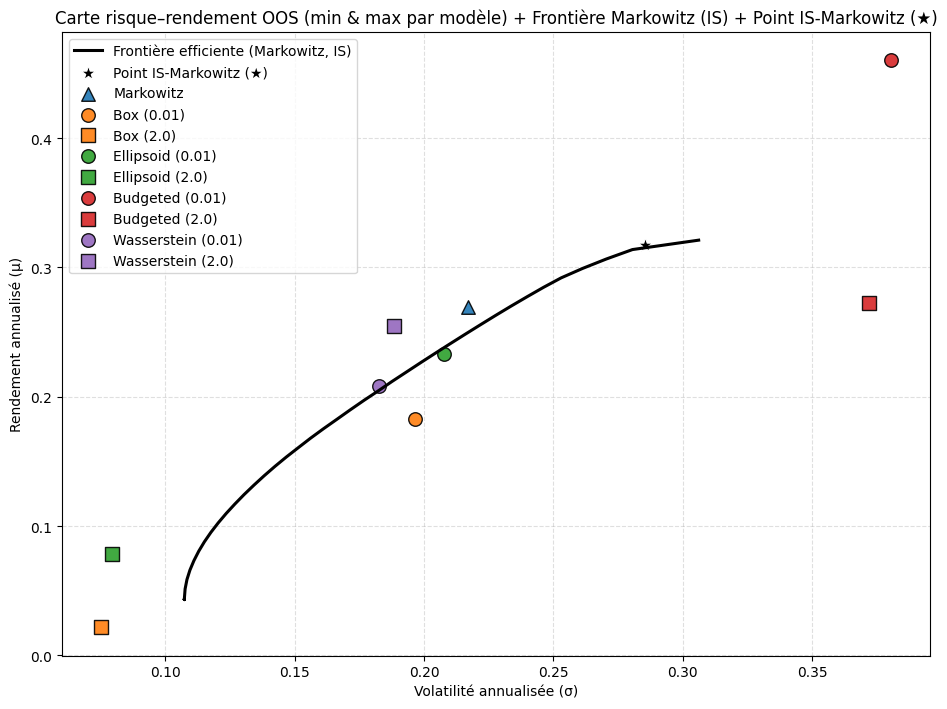

In [10]:
# %%
# =====================================================================
# Carte risque–rendement OOS (min & max par modèle) + Frontière Markowitz (IS)
# + Ajout du point Markowitz théorique IS (★) qui tombe sur la frontière
# =====================================================================
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt

# --- Couleurs fixes par modèle ---
COLOR_MAP = {
    "markowitz":  "#1f77b4",  # tab:blue
    "box":        "#ff7f0e",  # tab:orange
    "ellipsoid":  "#2ca02c",  # tab:green
    "budgeted":   "#d62728",  # tab:red
    "wasserstein":"#9467bd",  # tab:purple
}

def concat_oos_returns(nav_list):
    rets = [s.pct_change().dropna() for s in nav_list if isinstance(s, pd.Series) and len(s) > 1]
    if not rets:
        return pd.Series(dtype=float)
    return pd.concat(rets).sort_index()

def select_min_max_params(model_dict: dict):
    items = []
    for p, runs in (model_dict or {}).items():
        if runs:
            try:
                pf = float(p) if p is not None else None
            except Exception:
                pf = None
            items.append((p, runs, pf))
    if not items:
        return []
    def _minmax(pool):
        pool = sorted(pool, key=lambda it: it[2])
        if len(pool) == 1:
            return [pool[0]]
        lo, hi = pool[0], pool[-1]
        if lo[0] == hi[0]:
            return [lo]
        return [lo, hi]
    pos = [it for it in items if it[2] is not None and it[2] > 0.0]
    if pos:
        return _minmax(pos)
    nums = [it for it in items if it[2] is not None]
    if nums:
        return _minmax(nums)
    items = sorted(items, key=lambda it: str(it[0]))
    if len(items) == 1:
        return [items[0]]
    return [items[0], items[-1]]

def annualize_return(ret_series, freq=252):
    if len(ret_series) == 0:
        return np.nan
    cum = (1 + ret_series).prod()
    return cum**(freq / len(ret_series)) - 1

def annualize_vol(ret_series, freq=252):
    if len(ret_series) == 0:
        return np.nan
    return ret_series.std() * np.sqrt(freq)

def _cap_feasible(n, cap):
    if cap is None:
        return None
    min_cap = 1.0 / n + 1e-6
    return cap if cap >= min_cap else min_cap

# --- Frontière efficiente Markowitz (IS) ---
def efficient_frontier_IS(is_slice, sel, n_points=60, long_only=True, cap=None, solver="ECOS"):
    Rlog_IS = is_slice[sel].copy()
    mu, cov = estimate_mean_cov(Rlog_IS, use_shrink=True)
    n = len(mu)

    # bornes min/max de rendement faisable
    w = cp.Variable(n)
    cons = [cp.sum(w) == 1]
    if long_only: cons.append(w >= 0)
    if cap is not None: cons.append(w <= cap)

    prob_max = cp.Problem(cp.Maximize(mu @ w), cons)
    try: prob_max.solve(solver=solver, verbose=False)
    except Exception: prob_max.solve(solver="SCS", verbose=False)
    mu_max = float(mu @ w.value) if w.value is not None else float(np.max(mu))

    w = cp.Variable(n)
    cons = [cp.sum(w) == 1]
    if long_only: cons.append(w >= 0)
    if cap is not None: cons.append(w <= cap)
    prob_min = cp.Problem(cp.Minimize(mu @ w), cons)
    try: prob_min.solve(solver=solver, verbose=False)
    except Exception: prob_min.solve(solver="SCS", verbose=False)
    mu_min = float(mu @ w.value) if w.value is not None else float(np.min(mu))

    targets = np.linspace(mu_min, mu_max, n_points)
    sigmas, mus = [], []
    for t in targets:
        w = cp.Variable(n)
        cons = [cp.sum(w) == 1, mu @ w >= t]
        if long_only: cons.append(w >= 0)
        if cap is not None: cons.append(w <= cap)
        obj = cp.Minimize(cp.quad_form(w, cov))
        prob = cp.Problem(obj, cons)
        try: prob.solve(solver=solver, verbose=False)
        except Exception: prob.solve(solver="SCS", verbose=False)
        if w.value is not None:
            wv = np.maximum(w.value, 0); s = float(wv.sum())
            wv = (wv / s) if s > 1e-12 else np.ones(n)/n
            m = float(mu @ wv); v = float(wv @ cov @ wv)
            sigmas.append(np.sqrt(max(v, 0.0)) * np.sqrt(252))
            mus.append(m * 252)
    return np.array(sigmas), np.array(mus), mu, cov

# --- Point Markowitz théorique IS (même λ & contraintes que tes runs) ---
def is_markowitz_point(mu, cov, lambda_risk=1.0, long_only=True, cap=None, solver="ECOS"):
    n = len(mu)
    w = cp.Variable(n)
    cons = [cp.sum(w) == 1]
    if long_only: cons.append(w >= 0)
    if cap is not None: cons.append(w <= cap)
    obj = cp.Maximize(mu @ w - lambda_risk * cp.quad_form(w, cov))
    prob = cp.Problem(obj, cons)
    try: prob.solve(solver=solver, verbose=False)
    except Exception: prob.solve(solver="SCS", verbose=False)
    if w.value is None:
        return np.nan, np.nan
    wv = np.maximum(w.value, 0); s = float(wv.sum())
    wv = (wv / s) if s > 1e-12 else np.ones(n)/n
    mu_ann = float(mu @ wv) * 252
    sig_ann = np.sqrt(float(wv @ cov @ wv)) * np.sqrt(252)
    return sig_ann, mu_ann

# --- Construire les points : Markowitz OOS + min&max par modèle ---
summary_points = []  # (model, label, μ_ann, σ_ann, tag)

# Markowitz OOS (agrégé)
mk_runs_all = []
for p, lst in results_nav_models.get("markowitz", {}).items():
    mk_runs_all += lst
r = concat_oos_returns(mk_runs_all)
if not r.empty:
    summary_points.append(("markowitz", "baseline", annualize_return(r), annualize_vol(r), "baseline"))

# Autres modèles : min & max
for model, dct in results_nav_models.items():
    if model == "markowitz": continue
    pairs = select_min_max_params(dct)
    for idx, (param, nav_list, _) in enumerate(pairs):
        rr = concat_oos_returns(nav_list)
        if rr.empty: continue
        tag = "min" if idx == 0 and len(pairs) > 0 else "max"
        summary_points.append((model, f"{param}", annualize_return(rr), annualize_vol(rr), tag))

summary_df = pd.DataFrame(summary_points, columns=["model", "param", "ann_ret", "ann_vol", "tag"])

# --- Frontière IS + étoile Markowitz IS ---
try:
    cap_val = ROBUST_CAP if "ROBUST_CAP" in globals() else None
    cap_eff_front = _cap_feasible(len(sel), cap_val) if cap_val is not None else None
    sigmas_front, mus_front, mu_IS, cov_IS = efficient_frontier_IS(is_slice, sel, n_points=60,
                                                                   long_only=True, cap=cap_eff_front)
    # Point Markowitz théorique IS (même LAMBDA_RISK)
    lambda_val = LAMBDA_RISK if "LAMBDA_RISK" in globals() else 1.0
    sig_mk_is, mu_mk_is = is_markowitz_point(mu_IS, cov_IS, lambda_risk=lambda_val,
                                             long_only=True, cap=cap_eff_front)
except Exception as e:
    sigmas_front, mus_front = np.array([]), np.array([])
    sig_mk_is, mu_mk_is = np.nan, np.nan
    print(f"⚠️ Frontière/point IS non tracés ({e})")

# --- Plot ---
plt.figure(figsize=(9.5, 7.2))

# Frontière efficiente IS
if len(sigmas_front) > 0:
    plt.plot(sigmas_front, mus_front, linestyle="-", linewidth=2.2, color="black",
             label="Frontière efficiente (Markowitz, IS)")

# Point Markowitz théorique IS (★) — sur la frontière
if not np.isnan(sig_mk_is):
    plt.scatter(sig_mk_is, mu_mk_is, s=120, marker="*", color="black",
                edgecolors="white", linewidths=0.8, label="Point IS-Markowitz (★)")

# Points OOS (min/max par modèle + baseline Markowitz)
marker_map = {"baseline": "^", "min": "o", "max": "s"}
for _, row in summary_df.iterrows():
    mdl = row["model"]
    color = COLOR_MAP.get(mdl, "gray")
    label = "Markowitz" if mdl == "markowitz" else f"{mdl.capitalize()} ({row['param']})"
    plt.scatter(row["ann_vol"], row["ann_ret"], s=95,
                marker=marker_map.get(row["tag"], "o"),
                edgecolors="black", alpha=0.9, color=color, label=label)

# Légende sans doublons
handles, labels = plt.gca().get_legend_handles_labels()
seen = {}
uniq_h, uniq_l = [], []
for h, l in zip(handles, labels):
    if l not in seen:
        seen[l] = True
        uniq_h.append(h); uniq_l.append(l)
plt.legend(uniq_h, uniq_l, loc="best")

plt.xlabel("Volatilité annualisée (σ)")
plt.ylabel("Rendement annualisé (μ)")
plt.title("Carte risque–rendement OOS (min & max par modèle) + Frontière Markowitz (IS) + Point IS-Markowitz (★)")
plt.grid(alpha=0.4, linestyle="--")
plt.tight_layout()
plt.show()


🎯 Paramètres sélectionnés (meilleur 'Sharpe médian par run', p>0 uniquement) :
 - Markowitz (baseline): n_runs=135, Sharpe=1.241, µ=26.92%, σ=21.69%
 - Box (param=0.01): n_runs=135, Sharpe=0.930 | médiane runs=0.648 (IQR=1.665), µ=18.27%, σ=19.63%
 - Ellipsoid (param=2.0): n_runs=135, Sharpe=0.993 | médiane runs=1.117 (IQR=3.166), µ=7.87%, σ=7.92%
 - Wasserstein (param=2.0): n_runs=135, Sharpe=1.351 | médiane runs=1.232 (IQR=1.976), µ=25.43%, σ=18.83%


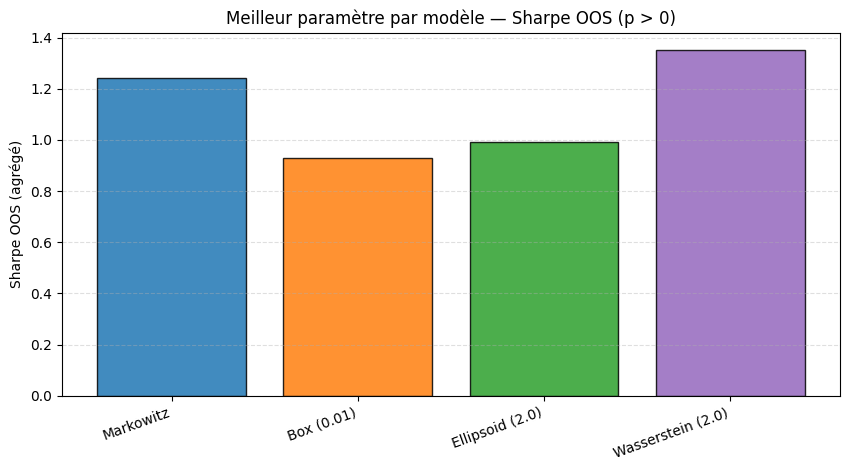

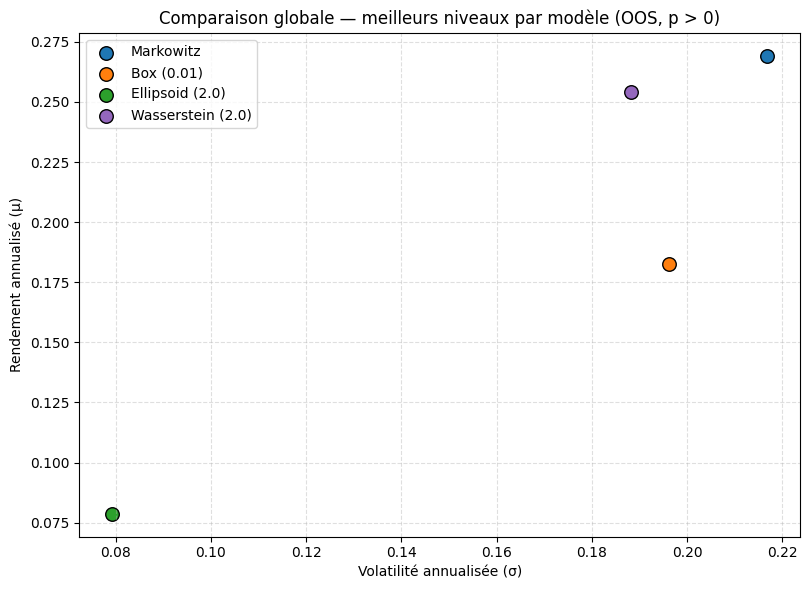

{'box': 0.01, 'ellipsoid': 2.0, 'wasserstein': 2.0}

In [11]:
# %%
# =====================================================================
# Cellule - Comparaison globale tous modèles (sélection auto du meilleur paramètre)
# Sélection = paramètre qui maximise la MÉDIANE du Sharpe OOS (par run)
# Tie-break: plus faible volatilité OOS, puis plus petit paramètre
# Règle ajoutée: on n'autorise que des paramètres STRICTEMENT > 0 pour les modèles robustes
# =====================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- couleurs fixes ---
COLOR_MAP = {
    "markowitz":  "#1f77b4",  # bleu
    "box":        "#ff7f0e",  # orange
    "ellipsoid":  "#2ca02c",  # vert
    "budgeted":   "#d62728",  # rouge
    "wasserstein":"#9467bd",  # violet
}

# --- utilitaires stats ---
def _ret_from_nav(nav: pd.Series) -> pd.Series:
    if not isinstance(nav, pd.Series) or len(nav) < 2:
        return pd.Series(dtype=float)
    return nav.pct_change().dropna()

def annualize_return(ret, freq=252):
    if isinstance(ret, list):
        ret = pd.concat(ret).sort_index() if ret else pd.Series(dtype=float)
    if len(ret) == 0: return np.nan
    cum = (1 + ret).prod()
    return cum**(freq/len(ret)) - 1

def annualize_vol(ret, freq=252):
    if isinstance(ret, list):
        ret = pd.concat(ret).sort_index() if ret else pd.Series(dtype=float)
    if len(ret) == 0: return np.nan
    return ret.std() * np.sqrt(freq)

def sharpe(ret):
    """Sharpe simple (rf=0)."""
    v = annualize_vol(ret)
    if v is None or v == 0 or np.isnan(v): 
        return np.nan
    return annualize_return(ret) / v

def _per_run_sharpes(nav_list):
    """Liste des Sharpe par run (rf=0)."""
    S = []
    for s in nav_list:
        r = _ret_from_nav(s)
        if len(r) > 0:
            S.append(sharpe(r))
    return [x for x in S if np.isfinite(x)]

def _agg_oos_ret(nav_list):
    """Concatène les retours OOS des runs (pour stats agrégées)."""
    rets = [_ret_from_nav(s) for s in nav_list if isinstance(s, pd.Series)]
    rets = [r for r in rets if len(r) > 0]
    if not rets:
        return pd.Series(dtype=float)
    return pd.concat(rets).sort_index()

def _is_positive_param(p):
    """True si p est convertible en float et strictement > 0."""
    try:
        return float(p) > 0.0
    except Exception:
        return False

def _select_best_param(model_name: str, results_nav_models: dict, tol=1e-6):
    """
    Choisit le param du modèle (STRICTEMENT > 0) qui maximise la médiane du Sharpe par run.
    Retourne: (best_param, summary_dict) ou (None, None) si vide.
    summary_dict = {
        'n_runs': int,
        'median_sharpe': float,
        'iqr_sharpe': float,
        'ann_ret_agg': float,
        'ann_vol_agg': float,
        'sharpe_agg': float
    }
    """
    dct = results_nav_models.get(model_name, {})
    if not dct:
        return None, None

    cand = []
    for p, nav_list in dct.items():
        # Markowitz n'a pas de paramètre ; pour les robustes on impose p > 0
        if model_name != "markowitz":
            if not _is_positive_param(p):
                continue
        if not nav_list:
            continue

        per_run_S = _per_run_sharpes(nav_list)
        if len(per_run_S) == 0:
            continue

        medS = np.nanmedian(per_run_S)
        q75, q25 = np.nanpercentile(per_run_S, [75, 25])
        iqrS = float(q75 - q25)

        ragg = _agg_oos_ret(nav_list)
        annR = annualize_return(ragg)
        annV = annualize_vol(ragg)
        Sagg = (annR/annV) if np.isfinite(annR) and np.isfinite(annV) and annV>0 else np.nan

        cand.append({
            "param": p,
            "n_runs": len(nav_list),
            "median_sharpe": float(medS),
            "iqr_sharpe": float(iqrS),
            "ann_ret_agg": float(annR) if np.isfinite(annR) else np.nan,
            "ann_vol_agg": float(annV) if np.isfinite(annV) else np.nan,
            "sharpe_agg": float(Sagg) if np.isfinite(Sagg) else np.nan
        })

    if not cand:
        return None, None

    # tri: médiane Sharpe desc, puis vol plus faible, puis param numérique croissant
    def _pfloat(x):
        try: return float(x)
        except: return np.inf

    cand.sort(key=lambda c: (-c["median_sharpe"],
                             c["ann_vol_agg"] if np.isfinite(c["ann_vol_agg"]) else np.inf,
                             _pfloat(c["param"])))
    best = cand[0]
    return best["param"], best

# === Sélection des meilleurs paramètres pour chaque modèle ===
best_by_model = {}
rows = []

# baseline Markowitz (agrégée)
mk_runs_all = []
for p, lst in results_nav_models.get("markowitz", {}).items():
    mk_runs_all += lst
mk_ragg = _agg_oos_ret(mk_runs_all)
mk_row = {
    "model": "markowitz",
    "param": None,
    "n_runs": len(mk_runs_all),
    "ann_ret": annualize_return(mk_ragg),
    "ann_vol": annualize_vol(mk_ragg),
}
mk_row["sharpe"] = (mk_row["ann_ret"]/mk_row["ann_vol"]) if (mk_row["ann_vol"] and mk_row["ann_vol"]>0) else np.nan
rows.append(mk_row)

for model in ["box", "ellipsoid", "wasserstein"]:
    pbest, summary = _select_best_param(model, results_nav_models)
    if pbest is None:
        print(f"⚠️ Aucun param exploitable (>0) pour {model}.")
        continue
    best_by_model[model] = pbest
    rows.append({
        "model": model,
        "param": pbest,
        "n_runs": summary["n_runs"],
        "ann_ret": summary["ann_ret_agg"],
        "ann_vol": summary["ann_vol_agg"],
        "sharpe": summary["sharpe_agg"],
        "median_sharpe_runs": summary["median_sharpe"],
        "iqr_sharpe_runs": summary["iqr_sharpe"],
    })

summary_df = pd.DataFrame(rows)
# ordonner: Markowitz d'abord puis tri par Sharpe décroissant
order = ["markowitz", "box", "ellipsoid", "budgeted", "wasserstein"]
summary_df["model"] = pd.Categorical(summary_df["model"], categories=order, ordered=True)
summary_df = summary_df.sort_values(["model", "sharpe"], ascending=[True, False]).reset_index(drop=True)

print("🎯 Paramètres sélectionnés (meilleur 'Sharpe médian par run', p>0 uniquement) :")
for _, r in summary_df.iterrows():
    if r["model"] == "markowitz":
        print(f" - Markowitz (baseline): n_runs={int(r['n_runs'])}, Sharpe={r['sharpe']:.3f}, "
              f"µ={r['ann_ret']:.2%}, σ={r['ann_vol']:.2%}")
    else:
        print(f" - {r['model'].capitalize()} (param={r['param']}): n_runs={int(r['n_runs'])}, "
              f"Sharpe={r['sharpe']:.3f} | médiane runs={r.get('median_sharpe_runs', np.nan):.3f} "
              f"(IQR={r.get('iqr_sharpe_runs', np.nan):.3f}), µ={r['ann_ret']:.2%}, σ={r['ann_vol']:.2%}")

# === Visualisation 1 : barres de Sharpe (baselined) ===
plt.figure(figsize=(8.6, 4.8))
plot_df = summary_df.copy()
bar_labels = [("Markowitz" if m=="markowitz" else f"{m.capitalize()} ({p})")
              for m,p in zip(plot_df["model"], plot_df["param"])]
colors = [COLOR_MAP.get(m, "gray") for m in plot_df["model"]]
plt.bar(bar_labels, plot_df["sharpe"], color=colors, edgecolor="black", alpha=0.85)
plt.xticks(rotation=20, ha="right")
plt.ylabel("Sharpe OOS (agrégé)")
plt.title("Meilleur paramètre par modèle — Sharpe OOS (p > 0)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# === Visualisation 2 : scatter µ-σ des 'meilleurs niveaux' vs Markowitz ===
plt.figure(figsize=(8.2, 6.0))
for _, r in summary_df.iterrows():
    mdl = r["model"]
    color = COLOR_MAP.get(mdl, "gray")
    label = "Markowitz" if mdl == "markowitz" else f"{mdl.capitalize()} ({r['param']})"
    plt.scatter(r["ann_vol"], r["ann_ret"], s=95, color=color, edgecolors="black", label=label)
# légende sans doublons
handles, labels = plt.gca().get_legend_handles_labels()
seen = {}
uh, ul = [], []
for h, l in zip(handles, labels):
    if l not in seen:
        seen[l] = True
        uh.append(h); ul.append(l)
plt.legend(uh, ul, loc="best")
plt.xlabel("Volatilité annualisée (σ)")
plt.ylabel("Rendement annualisé (µ)")
plt.title("Comparaison globale — meilleurs niveaux par modèle (OOS, p > 0)")
plt.grid(alpha=0.4, linestyle="--")
plt.tight_layout()
plt.show()

# Pour réutilisation ultérieure (ex: backtests finaux)
BEST_PARAMS_BY_MODEL = {row["model"]: row["param"] for _, row in summary_df.iterrows() if row["model"] != "markowitz"}
BEST_PARAMS_BY_MODEL


μ_IS = 0.009, σ_IS = 0.468
μ_OOS = 0.201, σ_OOS = 0.491


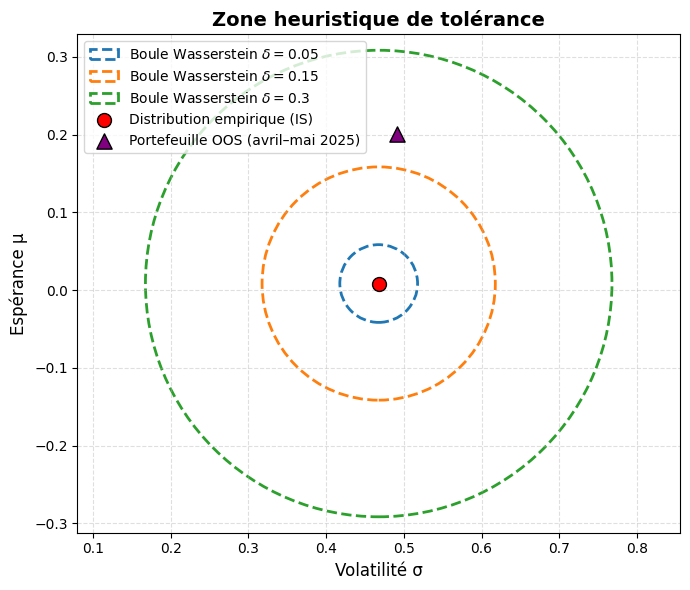

In [12]:
# =====================================================================
# Boule Wasserstein + point IS/OOS
# =====================================================================

# ---------- 1) Stats réelles IS / OOS ----------
mu_emp = is_slice.mean().mean() * 252               # rendement annualisé moyen IS
sigma_emp = is_slice.stack().std() * np.sqrt(252)   # volatilité annualisée IS

mu_oos = oos_slice.mean().mean() * 252              # rendement annualisé moyen OOS
sigma_oos = oos_slice.stack().std() * np.sqrt(252)  # volatilité annualisée OOS

print(f"μ_IS = {mu_emp:.3f}, σ_IS = {sigma_emp:.3f}")
print(f"μ_OOS = {mu_oos:.3f}, σ_OOS = {sigma_oos:.3f}")



# ---------- 3) Tracé ----------
delta_values = [0.05, 0.15, 0.3]
colors = ["tab:blue", "tab:orange", "tab:green"]

plt.figure(figsize=(7, 6))

# Boules Wasserstein
for d, color in zip(delta_values, colors):
    circle = plt.Circle((sigma_emp, mu_emp), d, color=color, fill=False,
                        linestyle="--", linewidth=2, label=fr"Boule Wasserstein $\delta={d}$")
    plt.gca().add_patch(circle)


# Point IS
plt.scatter(sigma_emp, mu_emp, color="red", s=100, edgecolor="black", zorder=5,
            label=r"Distribution empirique (IS)")

# Point OOS
plt.scatter(sigma_oos, mu_oos, color="purple", s=120, marker="^", edgecolor="black", zorder=6,
            label=r"Portefeuille OOS (avril–mai 2025)")

plt.xlabel("Volatilité σ", fontsize=12)
plt.ylabel("Espérance μ", fontsize=12)
plt.title("Zone heuristique de tolérance", fontsize=14, weight="bold")
plt.legend(fontsize=10, loc="upper left")
plt.grid(alpha=0.4, linestyle="--")
plt.axis("equal")
plt.tight_layout()
plt.show()




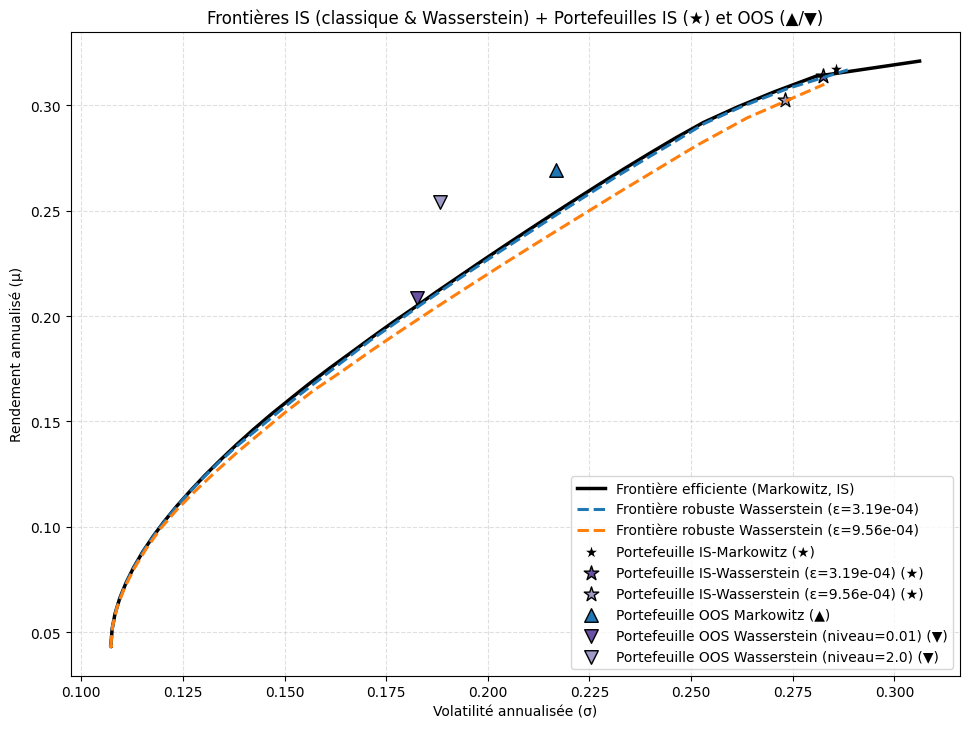

In [13]:
# %%
# =====================================================================
# Frontière IS classique & robuste (Wasserstein) + points IS/OOS (Markowitz & Wasserstein)
# =====================================================================

# --- petites utils ---
def _cap_feasible(n, cap):
    if cap is None: return None
    return cap if cap >= (1.0/n + 1e-6) else (1.0/n + 1e-6)

def annualize_return(ret_series, freq=252):
    if len(ret_series) == 0: return np.nan
    cum = (1 + ret_series).prod()
    return cum**(freq / len(ret_series)) - 1

def annualize_vol(ret_series, freq=252):
    if len(ret_series) == 0: return np.nan
    return ret_series.std() * np.sqrt(freq)

def concat_oos_returns(nav_list):
    rets = [s.pct_change().dropna() for s in nav_list if isinstance(s, pd.Series) and len(s) > 1]
    if not rets:
        return pd.Series(dtype=float)
    return pd.concat(rets).sort_index()

def select_min_max_params(model_dict: dict):
    """Retourne jusqu'à deux tuples (param, runs, p_float) : min & max (priorité aux p>0)."""
    items = []
    for p, runs in (model_dict or {}).items():
        if runs:
            try: pf = float(p) if p is not None else None
            except Exception: pf = None
            items.append((p, runs, pf))
    if not items:
        return []
    def _minmax(pool):
        pool = sorted(pool, key=lambda it: it[2])
        if len(pool) == 1: return [pool[0]]
        lo, hi = pool[0], pool[-1]
        return [lo] if lo[0] == hi[0] else [lo, hi]
    pos = [it for it in items if it[2] is not None and it[2] > 0.0]
    if pos: return _minmax(pos)
    nums = [it for it in items if it[2] is not None]
    if nums: return _minmax(nums)
    items = sorted(items, key=lambda it: str(it[0]))
    return [items[0]] if len(items) == 1 else [items[0], items[-1]]

# --- Estimation IS (mu, cov) sur l'univers 'sel' ---
Rlog_IS = is_slice[sel].copy()
mu_IS, cov_IS = estimate_mean_cov(Rlog_IS, use_shrink=True)
n = len(mu_IS)

# --- contraintes & lambda ---
cap_val = ROBUST_CAP if "ROBUST_CAP" in globals() else None
cap_eff = _cap_feasible(n, cap_val) if cap_val is not None else None
LAMBDA = LAMBDA_RISK if "LAMBDA_RISK" in globals() else 1.0

# === Frontière Markowitz (classique, IS) ===
def efficient_frontier(mu, cov, n_points=60, long_only=True, cap=None, solver="ECOS"):
    # bornes min/max de μ'w faisable
    w = cp.Variable(len(mu)); cons = [cp.sum(w) == 1]
    if long_only: cons.append(w >= 0)
    if cap is not None: cons.append(w <= cap)
    prob = cp.Problem(cp.Maximize(mu @ w), cons)
    try: prob.solve(solver=solver, verbose=False)
    except Exception: prob.solve(solver="SCS", verbose=False)
    mu_max = float(mu @ w.value) if w.value is not None else float(np.max(mu))

    w = cp.Variable(len(mu)); cons = [cp.sum(w) == 1]
    if long_only: cons.append(w >= 0)
    if cap is not None: cons.append(w <= cap)
    prob = cp.Problem(cp.Minimize(mu @ w), cons)
    try: prob.solve(solver=solver, verbose=False)
    except Exception: prob.solve(solver="SCS", verbose=False)
    mu_min = float(mu @ w.value) if w.value is not None else float(np.min(mu))

    targets = np.linspace(mu_min, mu_max, n_points)
    sig, ret = [], []
    for t in targets:
        w = cp.Variable(len(mu))
        cons = [cp.sum(w) == 1, mu @ w >= t]
        if long_only: cons.append(w >= 0)
        if cap is not None: cons.append(w <= cap)
        prob = cp.Problem(cp.Minimize(cp.quad_form(w, cov)), cons)
        try: prob.solve(solver=solver, verbose=False)
        except Exception: prob.solve(solver="SCS", verbose=False)
        if w.value is not None:
            wv = np.maximum(w.value, 0); s = float(wv.sum())
            wv = (wv / s) if s > 1e-12 else np.ones(len(mu))/len(mu)
            v = float(wv @ cov @ wv); m = float(mu @ wv)
            sig.append(np.sqrt(max(v, 0.0))*np.sqrt(252))
            ret.append(m*252)
    return np.array(sig), np.array(ret)

# === Frontière robuste Wasserstein (incertitude sur la moyenne) ===
#     min w'Σw s.c. μ'w - eps||w||_2 >= τ, 1'w=1, w≥0, w≤cap
def wasserstein_frontier(mu, cov, eps, n_points=60, long_only=True, cap=None, solver="ECOS"):
    # approx bornes de τ
    w = cp.Variable(len(mu)); cons = [cp.sum(w) == 1]
    if long_only: cons.append(w >= 0)
    if cap is not None: cons.append(w <= cap)
    try: cp.Problem(cp.Maximize(mu @ w), cons).solve(solver=solver, verbose=False)
    except Exception: cp.Problem(cp.Maximize(mu @ w), cons).solve(solver="SCS", verbose=False)
    mu_max_no_pen = float(mu @ w.value) if w.value is not None else float(np.max(mu))

    w = cp.Variable(len(mu)); cons = [cp.sum(w) == 1]
    if long_only: cons.append(w >= 0)
    if cap is not None: cons.append(w <= cap)
    try: cp.Problem(cp.Minimize(mu @ w), cons).solve(solver=solver, verbose=False)
    except Exception: cp.Problem(cp.Minimize(mu @ w), cons).solve(solver="SCS", verbose=False)
    mu_min_no_pen = float(mu @ w.value) if w.value is not None else float(np.min(mu))

    hi = mu_max_no_pen - eps/np.sqrt(len(mu))
    lo = mu_min_no_pen - eps
    targets = np.linspace(lo, hi, n_points)

    sig, ret = [], []
    for t in targets:
        w = cp.Variable(len(mu))
        cons = [cp.sum(w) == 1, mu @ w - eps*cp.norm2(w) >= t]
        if long_only: cons.append(w >= 0)
        if cap is not None: cons.append(w <= cap)
        prob = cp.Problem(cp.Minimize(cp.quad_form(w, cov)), cons)
        try: prob.solve(solver=solver, verbose=False)
        except Exception: prob.solve(solver="SCS", verbose=False)
        if w.value is not None:
            wv = np.maximum(w.value, 0); s = float(wv.sum())
            wv = (wv / s) if s > 1e-12 else np.ones(len(mu))/len(mu)
            v = float(wv @ cov @ wv); m = float(mu @ wv)
            sig.append(np.sqrt(max(v, 0.0))*np.sqrt(252))
            ret.append(m*252)
    return np.array(sig), np.array(ret)

# === Points IS (théoriques) ===
def is_markowitz_point(mu, cov, lambda_risk=1.0, long_only=True, cap=None, solver="ECOS"):
    w = cp.Variable(len(mu))
    cons = [cp.sum(w) == 1]
    if long_only: cons.append(w >= 0)
    if cap is not None: cons.append(w <= cap)
    prob = cp.Problem(cp.Maximize(mu @ w - lambda_risk * cp.quad_form(w, cov)), cons)
    try: prob.solve(solver=solver, verbose=False)
    except Exception: prob.solve(solver="SCS", verbose=False)
    if w.value is None: return np.nan, np.nan
    wv = np.maximum(w.value, 0); s = float(wv.sum())
    wv = (wv / s) if s > 1e-12 else np.ones(len(mu))/len(mu)
    mu_ann = float(mu @ wv) * 252
    sig_ann = np.sqrt(float(wv @ cov @ wv)) * np.sqrt(252)
    return sig_ann, mu_ann

def is_wasserstein_point(mu, cov, eps, lambda_risk=1.0, long_only=True, cap=None, solver="ECOS"):
    """Portefeuille 'robuste Wasserstein' : max μ'w - eps||w||_2 - λ w'Σw s.c. contraintes."""
    w = cp.Variable(len(mu))
    cons = [cp.sum(w) == 1]
    if long_only: cons.append(w >= 0)
    if cap is not None: cons.append(w <= cap)
    obj = cp.Maximize(mu @ w - eps*cp.norm2(w) - lambda_risk*cp.quad_form(w, cov))
    prob = cp.Problem(obj, cons)
    try: prob.solve(solver=solver, verbose=False)
    except Exception: prob.solve(solver="SCS", verbose=False)
    if w.value is None: return np.nan, np.nan
    wv = np.maximum(w.value, 0); s = float(wv.sum())
    wv = (wv / s) if s > 1e-12 else np.ones(len(mu))/len(mu)
    mu_ann = float(mu @ wv) * 252
    sig_ann = np.sqrt(float(wv @ cov @ wv)) * np.sqrt(252)
    return sig_ann, mu_ann

# === Frontières ===
sig_M, mu_M = efficient_frontier(mu_IS, cov_IS, n_points=60, long_only=True, cap=cap_eff)
mu_scale = float(np.mean(np.abs(mu_IS)))  # échelle daily de μ
epsilons = [0.5*mu_scale, 1.5*mu_scale]  # petit & grand rayon
frontiers = [ (eps,)+wasserstein_frontier(mu_IS, cov_IS, eps, n_points=60, long_only=True, cap=cap_eff)
              for eps in epsilons ]

# === Points IS ===
sig_mk_is, mu_mk_is = is_markowitz_point(mu_IS, cov_IS, lambda_risk=LAMBDA, long_only=True, cap=cap_eff)
wasserstein_is_points = [ (eps,)+is_wasserstein_point(mu_IS, cov_IS, eps, lambda_risk=LAMBDA,
                                                      long_only=True, cap=cap_eff)
                          for eps in epsilons ]

# === Points OOS (agrégés) ===
# Markowitz
mk_runs_all = []
for p, lst in results_nav_models.get("markowitz", {}).items():
    mk_runs_all += lst
r_oos = concat_oos_returns(mk_runs_all)
mu_mk_oos = annualize_return(r_oos)
sig_mk_oos = annualize_vol(r_oos)

# Wasserstein : min & max niveau parmi tes runs
w_pairs = select_min_max_params(results_nav_models.get("wasserstein", {}))
wasserstein_oos_points = []
for idx, (param, nav_list, _) in enumerate(w_pairs):
    rr = concat_oos_returns(nav_list)
    if not rr.empty:
        tag = "min" if idx == 0 else "max"
        wasserstein_oos_points.append((param, annualize_vol(rr), annualize_return(rr), tag))

# === Plot ===
plt.figure(figsize=(9.8, 7.4))
# Frontière classique
plt.plot(sig_M, mu_M, color="black", lw=2.5, label="Frontière efficiente (Markowitz, IS)")
# Frontières robustes
colors = ["#1f77b4", "#ff7f0e"]  # bleu/orange pour ε petit/grand
for (eps, s, m), c in zip(frontiers, colors):
    plt.plot(s, m, ls="--", lw=2.2, color=c, label=f"Frontière robuste Wasserstein (ε={eps:.2e})")

# Points IS
if not np.isnan(sig_mk_is):
    plt.scatter(sig_mk_is, mu_mk_is, s=120, marker="*", color="black",
                edgecolors="white", linewidths=0.8, label="Portefeuille IS-Markowitz (★)")
for (eps, sig_is, mu_is), c in zip(wasserstein_is_points, ["#6a51a3", "#9e9ac8"]):  # violets
    if np.isfinite(sig_is) and np.isfinite(mu_is):
        plt.scatter(sig_is, mu_is, s=120, marker="*", color=c, edgecolors="black",
                    label=f"Portefeuille IS-Wasserstein (ε={eps:.2e}) (★)")

# Points OOS
if np.isfinite(sig_mk_oos) and np.isfinite(mu_mk_oos):
    plt.scatter(sig_mk_oos, mu_mk_oos, s=95, marker="^", color="#1f77b4", edgecolors="black",
                label="Portefeuille OOS Markowitz (▲)")
for (param, sig_oos, mu_oos, tag), c in zip(wasserstein_oos_points, ["#6a51a3", "#9e9ac8"]):
    plt.scatter(sig_oos, mu_oos, s=95, marker="v", color=c, edgecolors="black",
                label=f"Portefeuille OOS Wasserstein (niveau={param}) (▼)")

plt.xlabel("Volatilité annualisée (σ)")
plt.ylabel("Rendement annualisé (μ)")
plt.title("Frontières IS (classique & Wasserstein) + Portefeuilles IS (★) et OOS (▲/▼)")
plt.grid(alpha=0.4, linestyle="--")

# Légende sans doublons
handles, labels = plt.gca().get_legend_handles_labels()
seen = {}
uniq_h, uniq_l = [], []
for h, l in zip(handles, labels):
    if l not in seen:
        seen[l] = True
        uniq_h.append(h); uniq_l.append(l)
plt.legend(uniq_h, uniq_l, loc="best")

plt.tight_layout()
plt.show()


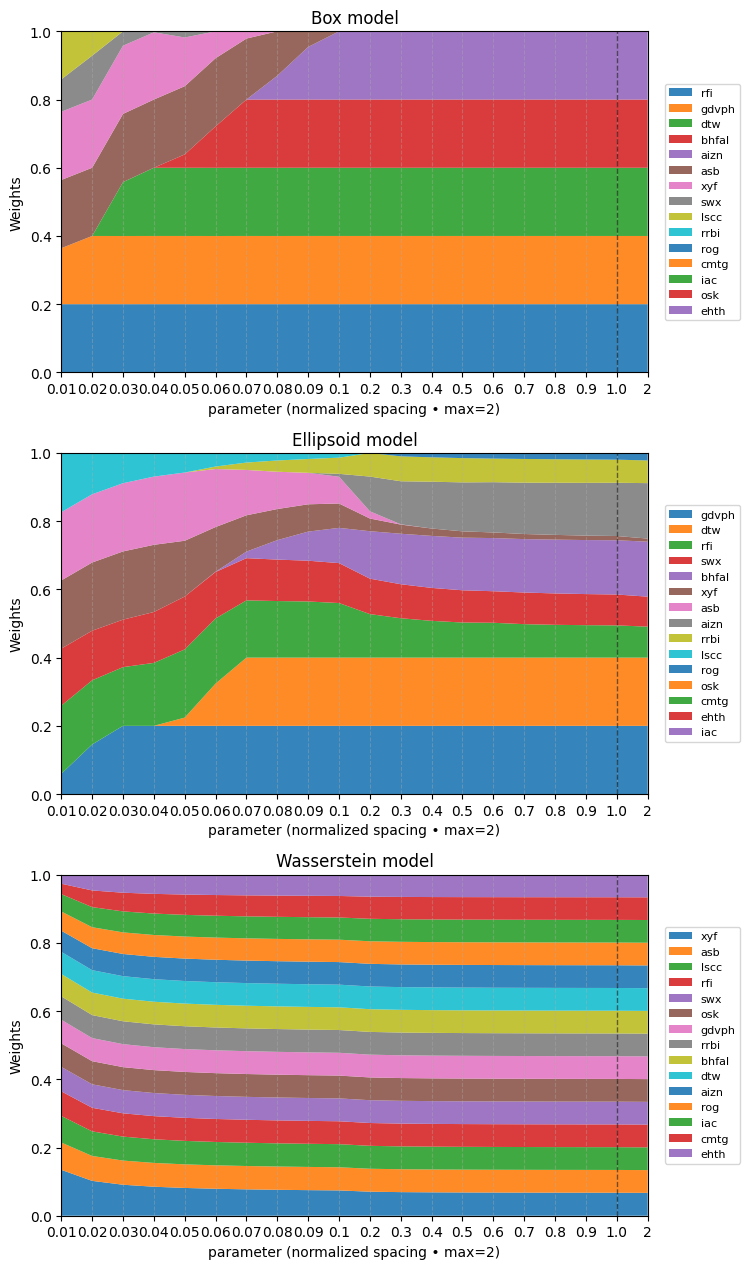

In [14]:
# =====================================================================
# Evolution of weights vs parameter (normalized spacing, max=2)
# =====================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _pfloat(p):
    try:    return float(p)
    except: return np.nan

def _fmt_param(p):
    p = float(p)
    if p < 0.1:            return f"{p:.2f}"   # 0.01, 0.05…
    if p <= 1.0 + 1e-12:   return f"{p:.1f}"   # 0.1…1.0
    return f"{int(round(p))}" if abs(p - round(p)) < 1e-12 else f"{p:.1f}"

def _avg_weights(series_list):
    if not series_list:
        return pd.Series(dtype=float)
    W = pd.concat(series_list, axis=1).fillna(0.0)
    return W.mean(axis=1)

def plot_weights_stacked_normalized(results_weights_models, pmax_display=2.0):
    models = [
        ("box",        "Box model"),
        ("ellipsoid",  "Ellipsoid model"),
        ("wasserstein","Wasserstein model"),
    ]
    fig, axes = plt.subplots(len(models), 1, figsize=(7.6, 12.8), sharex=False)
    if len(models) == 1: axes = [axes]

    for ax, (model, title) in zip(axes, models):
        dct = results_weights_models.get(model, {})
        if not dct:
            ax.text(0.5, 0.5, f"No runs for {model}", ha="center", va="center")
            ax.set_axis_off(); continue

        params, avgW = [], {}
        for p, lst in dct.items():
            pnum = _pfloat(p)
            if np.isnan(pnum) or pnum > pmax_display or not lst:
                continue
            s = _avg_weights(lst)
            if s.empty: continue
            params.append(pnum); avgW[pnum] = s

        if not params:
            ax.text(0.5, 0.5, f"No parameter ≤ {pmax_display} for {model}", ha="center", va="center")
            ax.set_axis_off(); continue

        params = sorted(params)
        all_assets = sorted(set().union(*[avgW[p].index for p in params]))
        M = pd.DataFrame(index=all_assets, columns=params, dtype=float)
        for p in params:
            M[p] = avgW[p].reindex(all_assets).fillna(0.0).values

        order_assets = M.sum(axis=1).sort_values(ascending=False).index.tolist()
        M = M.loc[order_assets, params]

        x = np.arange(len(params), dtype=float)
        Y = M.values
        ax.stackplot(x, *Y, labels=M.index.tolist(), alpha=0.9)

        labels = [_fmt_param(p) for p in params]
        ax.set_xticks(x, labels)

        ax.set_xlim(x.min(), x.max())
        ax.set_ylim(0.0, 1.0)
        ax.set_title(title)
        ax.set_xlabel("parameter (normalized spacing • max=2)")
        ax.set_ylabel("Weights")
        ax.grid(axis="x", linestyle="--", alpha=0.35)

        try:
            idx_one = next(i for i, p in enumerate(params) if abs(p - 1.0) < 1e-12)
            ax.axvline(x[idx_one], color="k", lw=1, ls="--", alpha=0.5)
        except StopIteration:
            pass

        ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5),
                  frameon=True, fontsize=8, ncol=1)

    plt.tight_layout(); plt.show()

# → run it
plot_weights_stacked_normalized(results_weights_models, pmax_display=2.0)


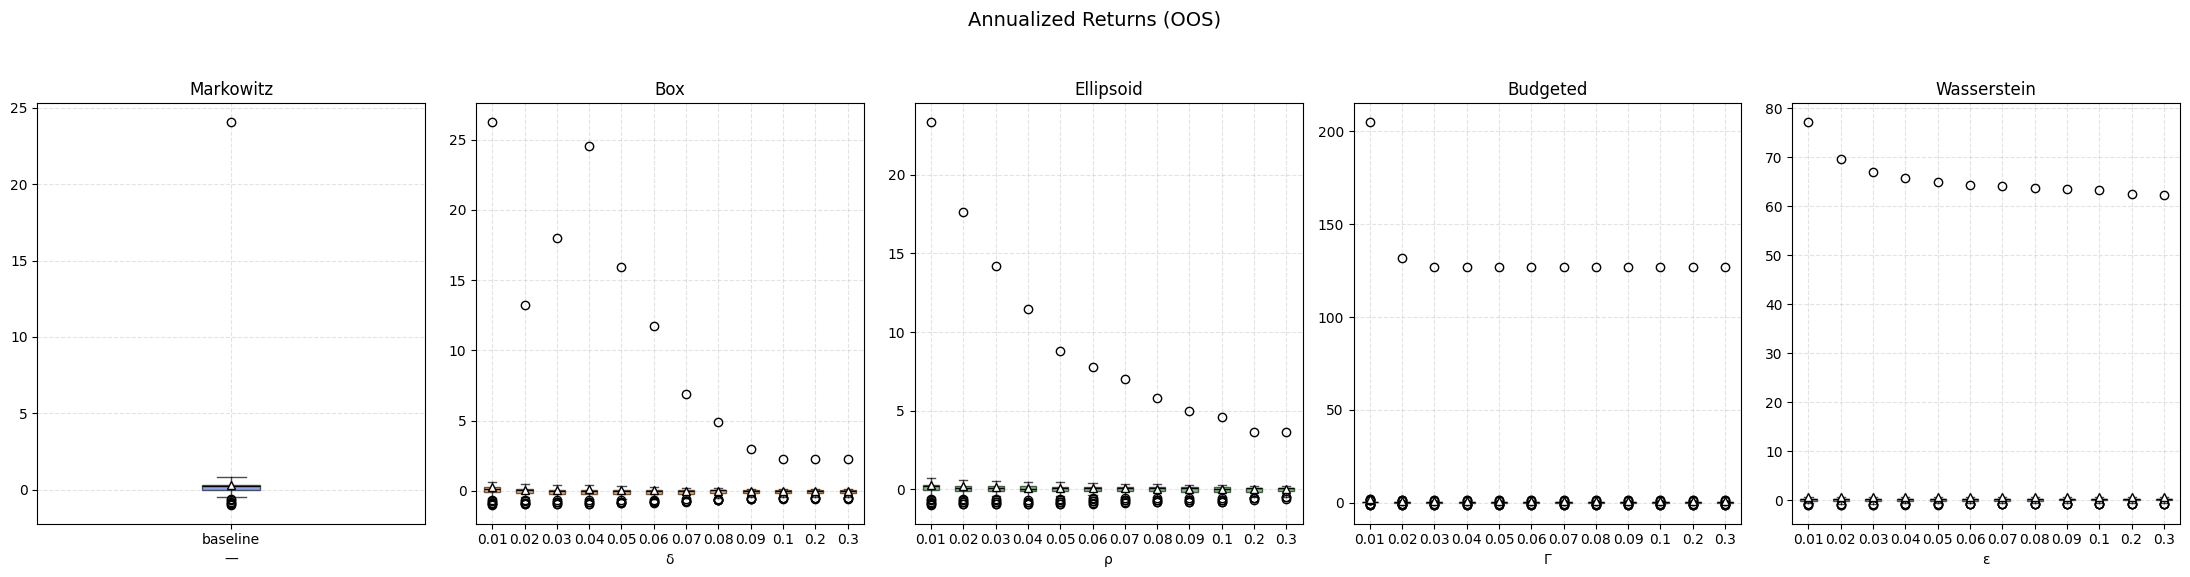

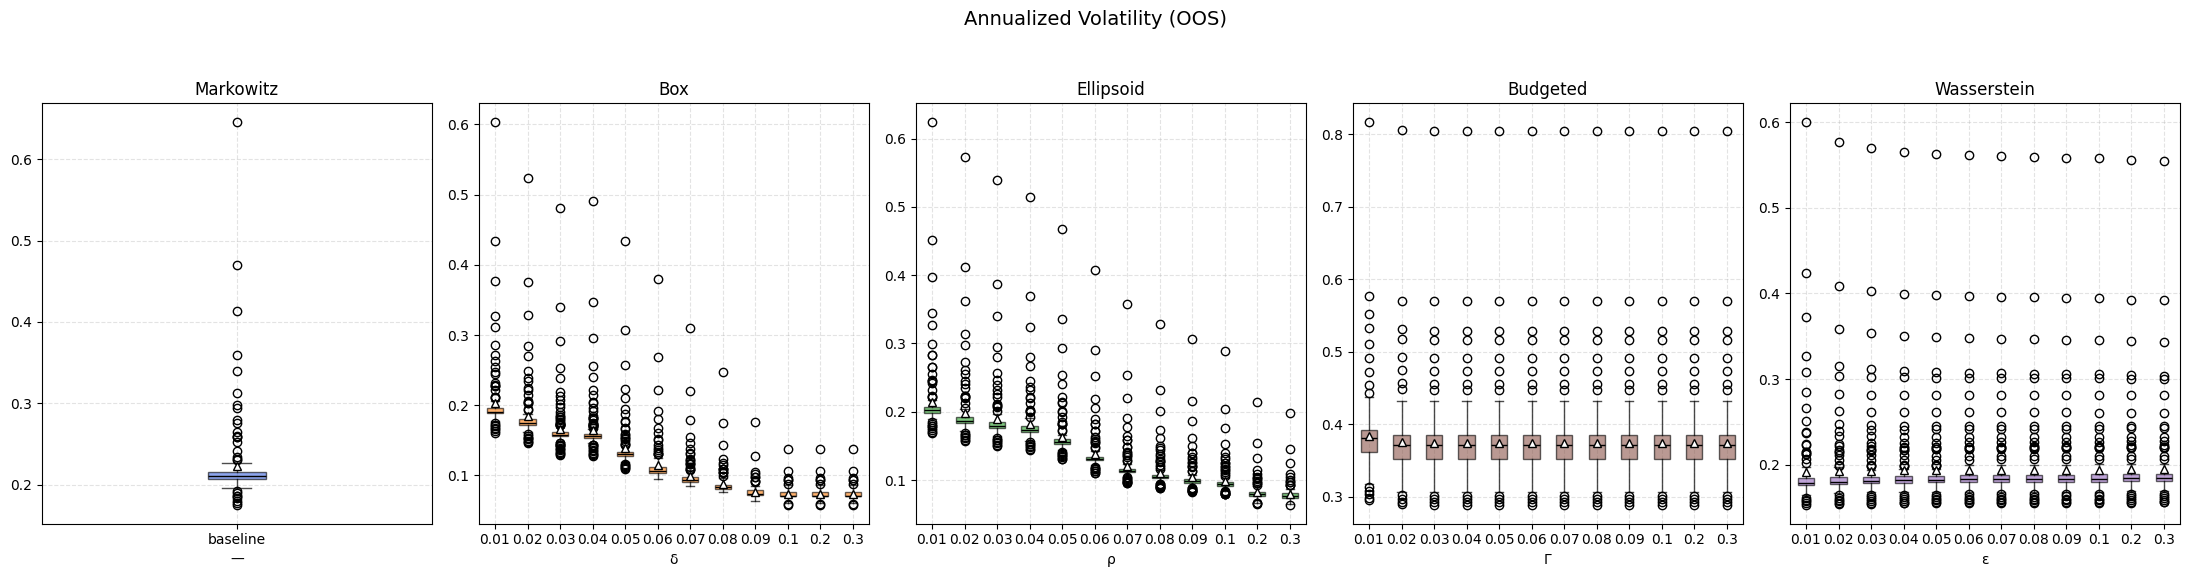

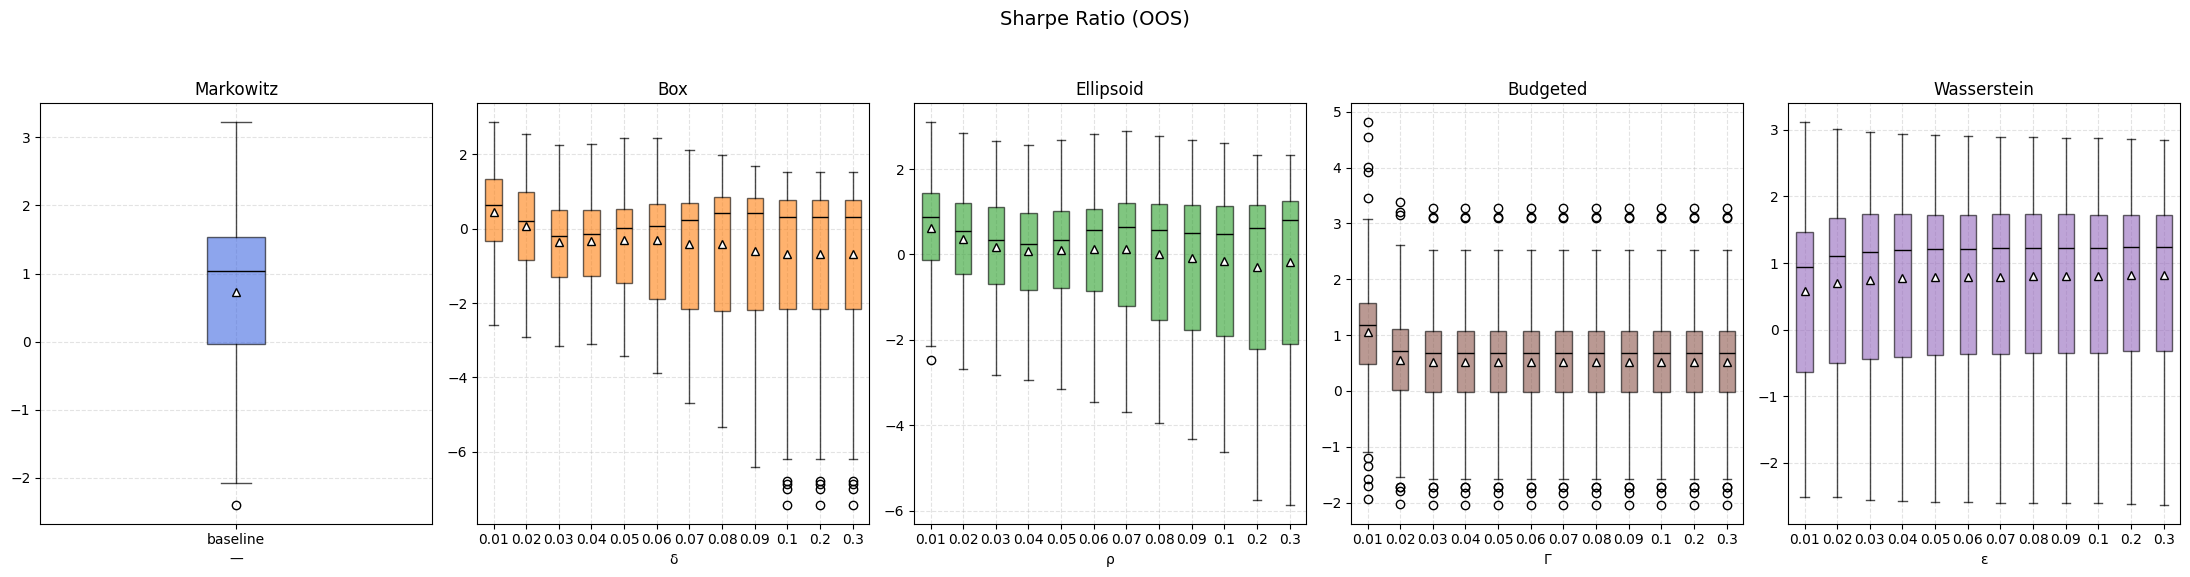

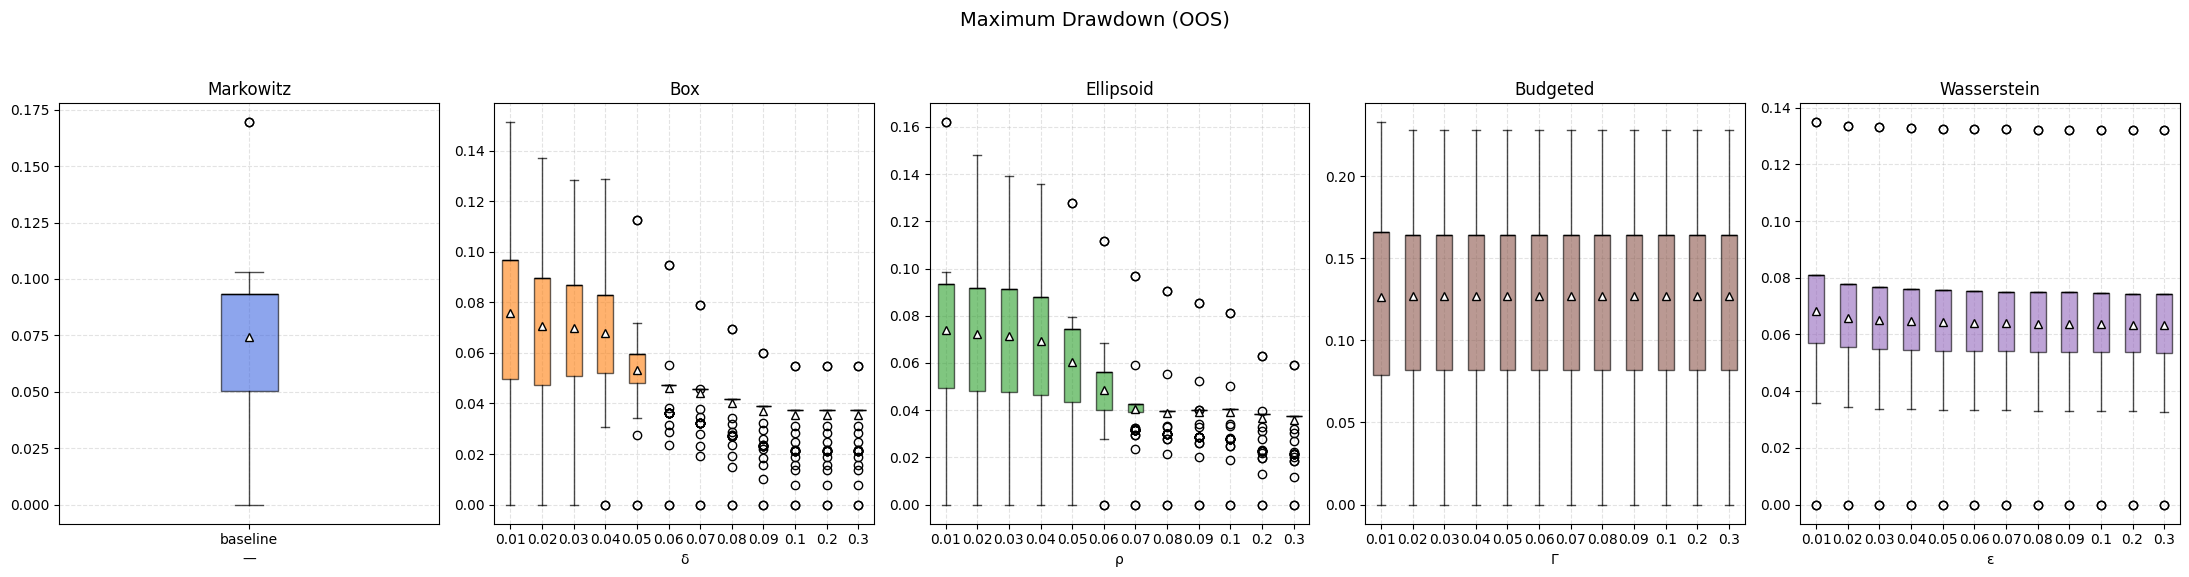

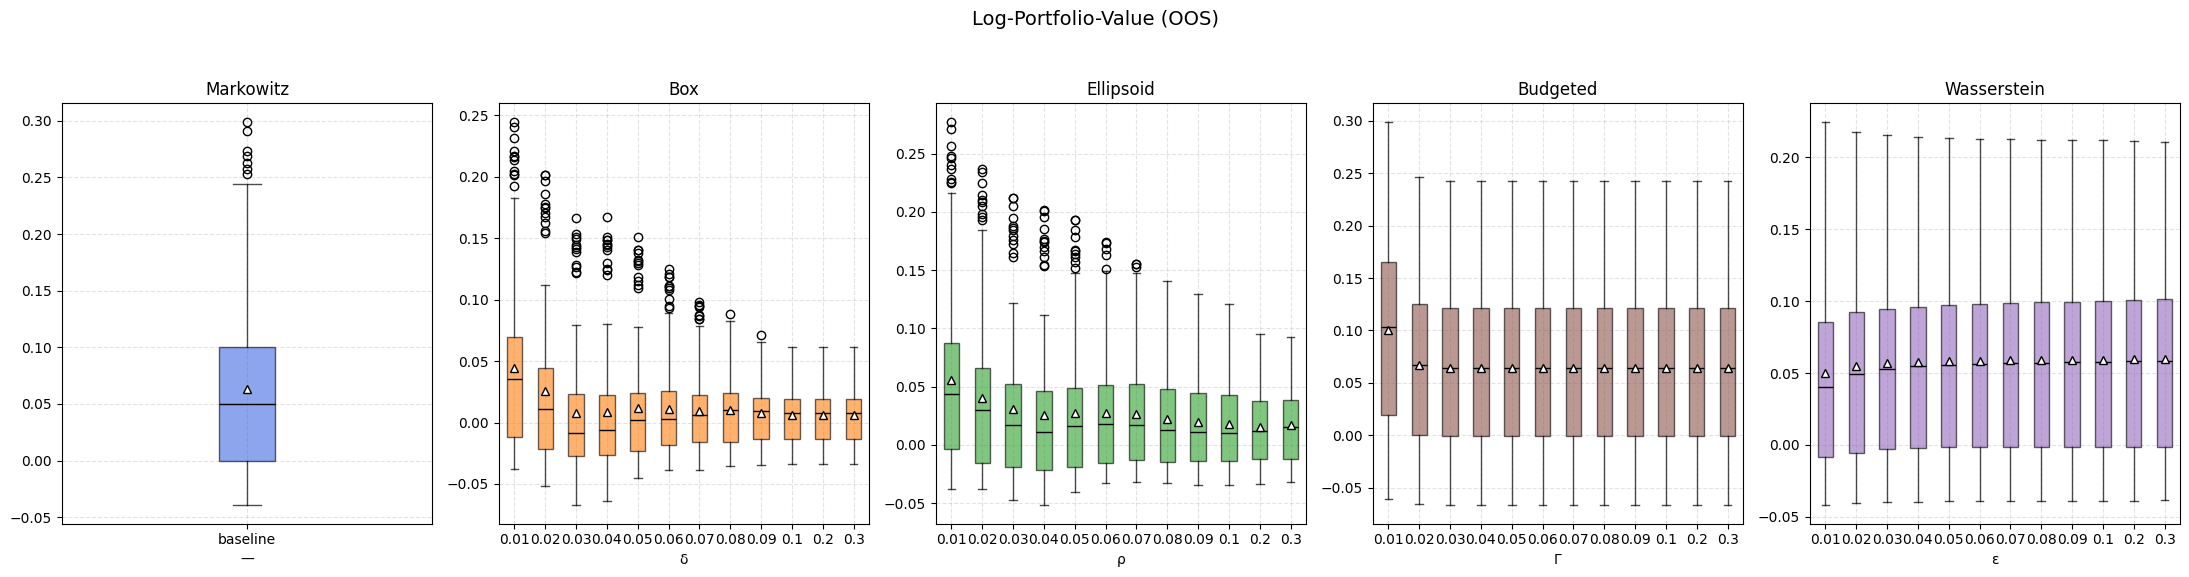

In [18]:
# %%
# ============================
# Boxplots per category (OOS) — dynamic params in [0.01, 0.30]
# ============================
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Presentation palette (fixed) ----
COLOR_MAP = {
    "markowitz":  "#4169e1",  # Royal Blue
    "box":        "#ff7f0e",  # Orange
    "ellipsoid":  "#2ca02c",  # Green
    "budgeted":   "#8c564b",  # Brown
    "wasserstein":"#9467bd",  # Purple
}

# ---- OOS NAV container ----
RESULTS_NAV = globals().get("results_nav_models_oos", None)
if RESULTS_NAV is None:
    RESULTS_NAV = globals().get("results_nav_models", {})

# ---- Parameter range filter ----
PARAM_MIN = 0.01
PARAM_MAX = 0.30
_BOUNDS_TOL = 1e-12  # tiny slack on bounds

# --------- utilities ----------
def _to_series(nav):
    if isinstance(nav, pd.Series):
        s = nav.copy()
    else:
        s = pd.Series(nav)
    return pd.to_numeric(s, errors="coerce")

def _nav_to_ret(nav):
    # OOS returns from OOS NAV
    s = _to_series(nav)
    s = s.where((s > 0) & (s.shift(1) > 0))
    r = s.pct_change().replace([np.inf, -np.inf], np.nan).dropna()
    return r

def _ann_return(ret, freq=252):
    if ret.size == 0: return np.nan
    ret = ret.replace([np.inf, -np.inf], np.nan).dropna()
    if ret.size == 0: return np.nan
    gross = 1 + ret
    cum = gross.prod()
    return cum**(freq / len(gross)) - 1

def _ann_vol(ret, freq=252):
    if ret.size == 0: return np.nan
    ret = ret.replace([np.inf, -np.inf], np.nan).dropna()
    if ret.size == 0: return np.nan
    return ret.std() * np.sqrt(freq)

def _sharpe(ret, freq=252, rf=0.0):
    vol = _ann_vol(ret, freq=freq)
    if not np.isfinite(vol) or vol <= 0: return np.nan
    return (_ann_return(ret, freq=freq) - rf) / vol

def _max_drawdown(nav):
    s = _to_series(nav).dropna()
    if s.empty: return np.nan
    dd = 1 - s / s.cummax()
    return float(dd.max())

def _log_nav(nav):
    s = _to_series(nav).dropna()
    if s.empty or s.iloc[0] <= 0 or s.iloc[-1] <= 0: return np.nan
    return float(np.log(s.iloc[-1] / s.iloc[0]))

def _extract_float(x):
    if isinstance(x, (int, float)): return float(x)
    try:
        return float(x)
    except Exception:
        m = re.search(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?', str(x))
        return float(m.group(0)) if m else None

def _fmt_param(p):
    try:
        p = float(p)
    except Exception:
        return str(p)
    if p < 0.1:          return f"{p:.2f}"
    if p <= 1.0 + 1e-12: return f"{p:.1f}"
    return f"{int(round(p))}" if abs(p - round(p)) < 1e-12 else f"{p:.1f}"

# --------- models & categories ----------
SYM = {"box": "δ", "ellipsoid": "ρ", "budgeted": "Γ", "wasserstein": "ε", "markowitz": "—"}
MODELS = ["markowitz", "box", "ellipsoid", "budgeted", "wasserstein"]
CATS = [
    ("Annualized Returns", 0),
    ("Annualized Volatility", 1),
    ("Sharpe Ratio", 2),
    ("Maximum Drawdown", 3),
    ("Log-Portfolio-Value", 4),
]

# --------- dynamic param selection with range filter ----------
def _items_grid_dynamic(model):
    """
    Return list of (display_param, list_of_navs) for parameters that actually exist,
    but only keep params within [PARAM_MIN, PARAM_MAX]. Markowitz: flatten all runs.
    """
    dct = RESULTS_NAV.get(model, {})
    if not dct:
        return []

    if model == "markowitz":
        all_runs = []
        for _, navs in dct.items():
            if navs:
                all_runs += navs
        return [(None, all_runs)] if all_runs else []

    # Collect numeric params that have runs and fall in [PARAM_MIN, PARAM_MAX]
    avail = []
    for k, navs in dct.items():
        if not navs:
            continue
        v = _extract_float(k)
        if v is None:
            continue
        vv = float(v)
        if (vv >= PARAM_MIN - _BOUNDS_TOL) and (vv <= PARAM_MAX + _BOUNDS_TOL):
            avail.append((vv, navs))

    if not avail:
        return []

    avail.sort(key=lambda t: t[0])  # ascending param values
    return avail  # list of (param_value, navs)

def _metric_lists(navs):
    R = []; V = []; S = []; M = []; L = []
    for nav in navs:
        r = _nav_to_ret(nav)
        R.append(_ann_return(r))
        V.append(_ann_vol(r))
        S.append(_sharpe(r))
        M.append(_max_drawdown(nav))
        L.append(_log_nav(nav))
    # Clean non-finite values (boxplot doesn't like NaN-only lists)
    R = [x for x in R if np.isfinite(x)]
    V = [x for x in V if np.isfinite(x)]
    S = [x for x in S if np.isfinite(x)]
    M = [x for x in M if np.isfinite(x)]
    L = [x for x in L if np.isfinite(x)]
    return R, V, S, M, L

# --------- precompute metrics ----------
pre = {}
for m in MODELS:
    items = _items_grid_dynamic(m)
    if m == "markowitz":
        labels = ["baseline"] if items else []
    else:
        labels = [_fmt_param(p) for p, _ in items]
    mats = {0:[], 1:[], 2:[], 3:[], 4:[]}
    for p, navs in items:
        R, V, S, M, L = _metric_lists(navs)
        mats[0].append(R); mats[1].append(V); mats[2].append(S); mats[3].append(M); mats[4].append(L)
    pre[m] = {"labels": labels, "data": mats}

# --------- plotting (category by category) ----------
for title, idx in CATS:
    fig, axes = plt.subplots(1, len(MODELS), figsize=(22, 5.5), sharey=False)
    for ax, m in zip(axes, MODELS):
        D  = pre[m]["data"][idx]
        lbl= pre[m]["labels"]

        # Keep only non-empty boxes
        D2, L2 = [], []
        for vals, lab in zip(D, lbl):
            if isinstance(vals, (list, tuple)) and len(vals) > 0:
                D2.append(vals); L2.append(lab)

        ax.set_title(m.capitalize())
        if not D2:
            ax.text(0.5, 0.5, "No OOS data in [0.01, 0.30]", ha="center", va="center", fontsize=10)
            ax.axis("off")
            continue

        bp = ax.boxplot(
            D2, showmeans=True, patch_artist=True,
            meanprops=dict(marker="^", markeredgecolor="black", markerfacecolor="white"),
            medianprops=dict(color="black"),
            whiskerprops=dict(alpha=0.7), capprops=dict(alpha=0.7)
        )
        # color the boxes by model
        base_color = COLOR_MAP.get(m, "lightgray")
        for patch in bp["boxes"]:
            patch.set_facecolor(base_color)
            patch.set_alpha(0.6)
            patch.set_edgecolor("black")

        ax.set_xticklabels(L2)
        ax.set_xlabel(SYM.get(m, "λ"))
        ax.grid(True, linestyle="--", alpha=0.35)

    fig.suptitle(title + " (OOS)", y=1.04, fontsize=14)
    fig.tight_layout()
    plt.show()
